<a href="https://colab.research.google.com/github/fnoritomi/projeto_sih/blob/main/sih_dengue_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de dados de dengue no Distrito Federal

## Instalação da biblioteca PySUS

Foi utilizada a biblioteca PySUS para facilitar o download de dados do SIH

[https://github.com/AlertaDengue/PySUS](https://github.com/AlertaDengue/PySUS)

In [ ]:
!sudo apt install libffi-dev

In [ ]:
!sudo pip install PySUS

## Carregamento das bibliotecas e configurações do Notebook

In [ ]:
from pysus.ftp.databases.sih import SIH

In [458]:
import pandas as pd
import duckdb
import os
import shutil
from google.colab import files
from google.colab import drive
from google.colab import output

# Monta o Google Drive no Workspace do Notebook
drive.mount('/content/drive')

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_info_columns', 200)


<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download de arquivos do SIH

Foram baixados arquivos da base reduzida de AIHs de 2020 a 2024, os quais foram salvos em formato parquet para reduzir o espaço de armazenamento e facilitar a leitura.

In [ ]:
sih = SIH().load() # Carrega lista de arquivos do DATASUS
files = sih.get_files("RD", uf="DF", year=[ano for ano in range(2020, 2025)])
sih_files = sih.download(files)

RDDF2411.parquet: 100%|██████████| 69.3k/69.3k [00:03<00:00, 17.8kB/s]


In [ ]:
pasta_destino = '/content/drive/MyDrive/Colab Notebooks/Dados/sih'

for pasta in [str(parquet) for parquet in sih_files]:
  nome_pasta = os.path.basename(pasta)
  destino = os.path.join(pasta_destino, nome_pasta)
  if os.path.exists(destino):
    shutil.rmtree(destino)
  if os.path.exists(pasta):
    shutil.move(pasta, pasta_destino)

In [3]:
pasta_destino = '/content/drive/MyDrive/Colab Notebooks/Dados/sih'
pastas_parquet = [os.path.join(pasta_destino, pasta) for pasta in next(os.walk(pasta_destino))[1] if pasta.endswith("parquet")]

## Carga de dados de internações por dengue no DF

Antes da primeira carga de dados, foi estudada a documentação da base para identificar quais variáveis interessam à análise.

A documentação informa que são zerados ou descontinuados os campos UTI_MES_IN, UTI_MES_AN, UTI_MES_AL, VAL_SADT, VAL_RN, VAL_ACOMP, VAL_ORTP, VAL_SANGUE, VAL_SADTSR, VAL_TRANSP, VAL_OBSANG, VAL_PED1AC, NATUREZA, RUBRICA, NUM_PROC, TOT_PT_SP, CPF_AUT, motivo pelo qual eles nem devem ser carregados.

Dos campos restantes, foram selecionados inicialmente: ANO_CMPT, MES_CMPT, ESPEC, CGC_HOSP, N_AIH, IDENT, MUNIC_RES, SEXO, UTI_MES_TO, MARCA_UTI,  UTI_INT_TO, DIAR_ACOM, QT_DIARIAS, PROC_SOLIC, PROC_REA, VAL_SH, VAL_SP, VAL_TOT, VAL_UTI, DT_INTER, DT_SAIDA, DIAG_PRINC, DIAG_SECUN, COBRANCA, NAT_JUR, MUNIC_MOV, COD_IDADE, IDADE, DIAS_PERM, MORTE, NACIONAL, CAR_INT, NUM_FILHOS, INSTRU, CID_NOTIF, CONTRACEP1, CONTRACEP2, GESTRISCO, INSC_PN, SEQ_AIH5, CBOR, CNAER, VINCPREV, CNES, CNPJ_MANT, INFEHOSP, CID_ASSO, CID_MORTE, COMPLEX, RACA_COR, ETNIA, DIAGSEC1, DIAGSEC2, DIAGSEC3, DIAGSEC4, DIAGSEC5, DIAGSEC6, DIAGSEC7, DIAGSEC8, DIAGSEC9, TPDISEC1, TPDISEC2, TPDISEC3, TPDISEC4, TPDISEC5, TPDISEC6, TPDISEC7, TPDISEC8, TPDISEC9.

Os dados filtrados para carregar apenas AIHs com diagnóstico principal de dengue (CID A90 - dengue clássica, ou CID A91 - dengue hemorrágica) ou com procedimento realizado 03.03.01.001-0 - TRATAMENTO DE DENGUE CLÁSSICA, ou 03.03.01.002-9 - TRATAMENTO DE DENGUE HEMORRÁGICA.


In [377]:
colunas = [
    'ANO_CMPT',
    'MES_CMPT',
    'ESPEC',
    'CGC_HOSP',
    'N_AIH',
    'IDENT',
    'MUNIC_RES',
    'SEXO',
    'UTI_MES_TO',
    'MARCA_UTI',
    'UTI_INT_TO',
    'DIAR_ACOM',
    'QT_DIARIAS',
    'PROC_SOLIC',
    'PROC_REA',
    'VAL_SH',
    'VAL_SP',
    'VAL_TOT',
    'VAL_UTI',
    'DT_INTER',
    'DT_SAIDA',
    'DIAG_PRINC',
    'DIAG_SECUN',
    'COBRANCA',
    'NAT_JUR',
    'MUNIC_MOV',
    'COD_IDADE',
    'IDADE',
    'DIAS_PERM',
    'MORTE',
    'NACIONAL',
    'CAR_INT',
    'NUM_FILHOS',
    'INSTRU',
    'CID_NOTIF',
    'CONTRACEP1',
    'CONTRACEP2',
    'GESTRISCO',
    'INSC_PN',
    'SEQ_AIH5',
    'CBOR',
    'CNAER',
    'VINCPREV',
    'CNES',
    'CNPJ_MANT',
    'INFEHOSP',
    'CID_ASSO',
    'CID_MORTE',
    'COMPLEX',
    'RACA_COR',
    'ETNIA',
    'DIAGSEC1',
    'DIAGSEC2',
    'DIAGSEC3',
    'DIAGSEC4',
    'DIAGSEC5',
    'DIAGSEC6',
    'DIAGSEC7',
    'DIAGSEC8',
    'DIAGSEC9',
    'TPDISEC1',
    'TPDISEC2',
    'TPDISEC3',
    'TPDISEC4',
    'TPDISEC5',
    'TPDISEC6',
    'TPDISEC7',
    'TPDISEC8',
    'TPDISEC9'
  ]

filtros = [('DIAG_PRINC', )]

def ler_parquet(pasta, colunas):
  df = pd.read_parquet(pasta, engine='pyarrow', columns = colunas)
  df = df[(df.DIAG_PRINC.isin(['A90 ', 'A91 ']))|(df.PROC_REA.isin(['0303010010', '0303010029']))]
  return df

dengue_df = pd.concat([ler_parquet(pasta, colunas) for pasta in pastas_parquet], ignore_index=True)

In [378]:
dengue_df.head()

,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,MUNIC_RES,SEXO,UTI_MES_TO,MARCA_UTI,UTI_INT_TO,DIAR_ACOM,QT_DIARIAS,PROC_SOLIC,PROC_REA,VAL_SH,VAL_SP,VAL_TOT,VAL_UTI,DT_INTER,DT_SAIDA,DIAG_PRINC,DIAG_SECUN,COBRANCA,NAT_JUR,MUNIC_MOV,COD_IDADE,IDADE,DIAS_PERM,MORTE,NACIONAL,CAR_INT,NUM_FILHOS,INSTRU,CID_NOTIF,CONTRACEP1,CONTRACEP2,GESTRISCO,INSC_PN,SEQ_AIH5,CBOR,CNAER,VINCPREV,CNES,CNPJ_MANT,INFEHOSP,CID_ASSO,CID_MORTE,COMPLEX,RACA_COR,ETNIA,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,DIAGSEC5,DIAGSEC6,DIAGSEC7,DIAGSEC8,DIAGSEC9,TPDISEC1,TPDISEC2,TPDISEC3,TPDISEC4,TPDISEC5,TPDISEC6,TPDISEC7,TPDISEC8,TPDISEC9
0,2022,01,03,,5321102546991,1,530010,3,0,00,0,0,1,0303010010,0303010010,229.44,58.32,287.76,0.00,20220104,20220105,A90,0000,12,1023,530010,4,22,1,0,010,02,0,0,,00,00,1,000000000000,000,000000,000,0,2672197,00394700000108,,0000,0000,02,03,0000,,,,,,,,,,0,0,0,0,0,0,0,0,0
1,2022,01,03,00394700001422,5321102582004,1,530010,3,0,00,0,3,3,0303010010,0303010010,362.20,69.98,432.18,0.00,20211213,20211216,A90,0000,15,1023,530010,4,22,3,0,010,02,0,0,,00,00,1,000000000000,000,000000,000,0,0010502,00394700000108,,0000,0000,02,03,0000,,,,,,,,,,0,0,0,0,0,0,0,0,0
2,2022,01,07,00394700001422,5321102586140,1,530010,3,0,00,0,8,8,0303010010,0303010010,436.51,79.27,515.78,0.00,20211214,20211222,A90,0000,12,1023,530010,4,4,8,0,010,02,0,0,,00,00,1,000000000000,000,000000,000,0,0010502,00394700000108,,0000,0000,02,03,0000,,,,,,,,,,0,0,0,0,0,0,0,0,0
3,2022,01,03,00394700001422,5321102604675,1,530010,3,0,00,0,2,2,0303010010,0303010010,294.52,69.98,364.50,0.00,20211219,20211221,A90,0000,12,1023,530010,4,27,2,0,010,02,0,0,,00,00,1,000000000000,000,000000,000,0,0010502,00394700000108,,0000,0000,02,01,0000,,,,,,,,,,0,0,0,0,0,0,0,0,0
4,2022,01,03,00394700000370,5321102715577,1,530010,3,0,00,0,3,3,0303010029,0303010029,256.81,56.36,313.17,0.00,20220114,20220117,A91,0000,12,1023,530010,4,47,3,0,010,02,0,0,,00,00,1,000000000000,000,000000,000,0,2645157,00394700000108,,0000,0000,02,99,0000,,,,,,,,,,0,0,0,0,0,0,0,0,0


In [379]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ANO_CMPT    12330 non-null  object
 1   MES_CMPT    12330 non-null  object
 2   ESPEC       12330 non-null  object
 3   CGC_HOSP    12330 non-null  object
 4   N_AIH       12330 non-null  object
 5   IDENT       12330 non-null  object
 6   MUNIC_RES   12330 non-null  object
 7   SEXO        12330 non-null  object
 8   UTI_MES_TO  12330 non-null  object
 9   MARCA_UTI   12330 non-null  object
 10  UTI_INT_TO  12330 non-null  object
 11  DIAR_ACOM   12330 non-null  object
 12  QT_DIARIAS  12330 non-null  object
 13  PROC_SOLIC  12330 non-null  object
 14  PROC_REA    12330 non-null  object
 15  VAL_SH      12330 non-null  object
 16  VAL_SP      12330 non-null  object
 17  VAL_TOT     12330 non-null  object
 18  VAL_UTI     12330 non-null  object
 19  DT_INTER    12330 non-null  object
 20  DT_SAI

A inspeção inicial mostra que todos os dados estão com tipo 'object', inclusive os que deveriam ser numéricos.

Além disso, algumas colunas estão com apenas um único valor distinto, motivo pelo qual foram excluídas.

In [380]:
novos_nomes_colunas = {
    "ANO_CMPT": "ano",
    "MES_CMPT": "mes",
    "ESPEC": "cd_especialidade",
    "MUNIC_RES": "cd_municipio_res",
    "SEXO": "cd_sexo",
    "UTI_MES_TO": "qt_diarias_uti",
    "MARCA_UTI": "cd_tipo_uti",
    "UTI_INT_TO": "qt_diarias_uti_interm",
    "DIAR_ACOM": "qt_diarias_acompanhante",
    "QT_DIARIAS": "qt_diarias",
    "PROC_SOLIC": "cd_proc_solicitado",
    "PROC_REA": "cd_proc_realizado",
    "VAL_SH": "vl_sh",
    "VAL_SP": "vl_sp",
    "VAL_TOT": "vl_total",
    "VAL_UTI": "vl_uti",
    "DT_INTER": "dt_internacao",
    "DT_SAIDA": "dt_saida",
    "DIAG_PRINC": "cd_diag_princ",
    "COBRANCA": "cd_motivo_alta_perm",
    "NAT_JUR": "cd_natureza_juridica",
    "MUNIC_MOV": "cd_municipio_estab",
    "COD_IDADE": "cd_unidade_idade",
    "IDADE": "qt_idade",
    "DIAS_PERM": "qt_dias_permanencia",
    "MORTE": "cd_morte",
    "NACIONAL": "cd_nacionalidade",
    "CAR_INT": "cd_carater_atendimento",
    "CNES": "cd_cnes",
    "COMPLEX": "cd_complexidade",
    "RACA_COR": "cd_raca_cor",
    "DIAGSEC1": "cd_diag_sec_1",
    "DIAGSEC2": "cd_diag_sec_2",
    "DIAGSEC3": "cd_diag_sec_3",
    "DIAGSEC4": "cd_diag_sec_4",
    "DIAGSEC5": "cd_diag_sec_5",
    "TPDISEC1": "tp_diag_sec_1",
    "TPDISEC2": "tp_diag_sec_2",
    "TPDISEC3": "tp_diag_sec_3",
    "TPDISEC4": "tp_diag_sec_4",
    "TPDISEC5": "tp_diag_sec_5"
}
dengue_df = dengue_df[list(novos_nomes_colunas.keys())]
dengue_df = dengue_df.rename(columns=novos_nomes_colunas)

In [381]:
def ajustar_tipo(df, coluna):
  if coluna in ['ano', 'mes'] or coluna[0:3] in ['qt_', 'vl_']:
    df[coluna] = pd.to_numeric(df[coluna], errors="coerce")
  elif coluna[0:3] == 'dt_':
    df[coluna] = pd.to_datetime(df[coluna], format="%Y%m%d")
  else:
    df[coluna] = df[coluna].str.strip() # Remove espaços à direita e à esquerda

for coluna in dengue_df.columns:
  ajustar_tipo(dengue_df, coluna)

In [382]:
dengue_df['ano_internacao']=dengue_df['dt_internacao'].dt.year
dengue_df['mes_internacao']=dengue_df['dt_internacao'].dt.month
dengue_df['ano_saida']=dengue_df['dt_saida'].dt.year
dengue_df['mes_saida']=dengue_df['dt_saida'].dt.month

dengue_df = dengue_df[dengue_df['ano_saida']>=2020]

In [383]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12303 entries, 0 to 12329
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ano                      12303 non-null  int64         
 1   mes                      12303 non-null  int64         
 2   cd_especialidade         12303 non-null  object        
 3   cd_municipio_res         12303 non-null  object        
 4   cd_sexo                  12303 non-null  object        
 5   qt_diarias_uti           12303 non-null  int64         
 6   cd_tipo_uti              12303 non-null  object        
 7   qt_diarias_uti_interm    12303 non-null  int64         
 8   qt_diarias_acompanhante  12303 non-null  int64         
 9   qt_diarias               12303 non-null  int64         
 10  cd_proc_solicitado       12303 non-null  object        
 11  cd_proc_realizado        12303 non-null  object        
 12  vl_sh                    12303 non-nu

## Exploração de dados

In [384]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from IPython.display import display


def agregar_dados(df, dimesoes, medidas):
  df_agrupado = df.groupby(dimesoes)[medidas].agg(['count', 'sum', 'min', 'max', 'mean', 'std'])
  df_agrupado.columns = ['_'.join(col).strip() for col in df_agrupado.columns]  # Achata as colunas multi índice
  return df_agrupado.reset_index()

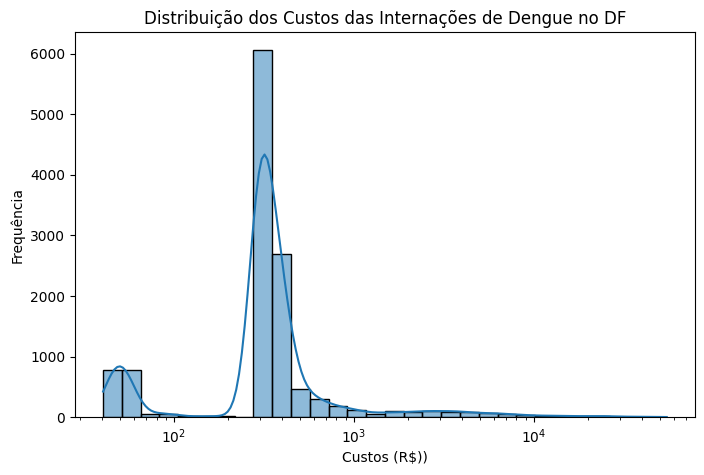

In [385]:
# Distribuição dos custos médicos
plt.figure(figsize=(8, 5))
sns.histplot(dengue_df['vl_total'], bins=30, kde=True, log_scale=(True, False))
plt.title("Distribuição dos Custos das Internações de Dengue no DF")
plt.xlabel("Custos (R$))")
plt.ylabel("Frequência")
plt.show()

### Evolução temporal

In [386]:
agregado_ano = agregar_dados(dengue_df, ['ano_saida'], ['vl_total'])

display(agregado_ano)

,ano_saida,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,2020,972,427039.38,44.22,23613.34,439.340926,968.613799
1,2021,460,183379.87,44.22,19017.10,398.651891,929.924190
2,2022,1435,673614.34,40.38,34135.46,469.417659,1412.247719
3,2023,1135,698913.53,40.38,34453.25,615.782846,1812.572529
4,2024,8301,6091330.40,40.38,54701.14,733.806818,2401.215654


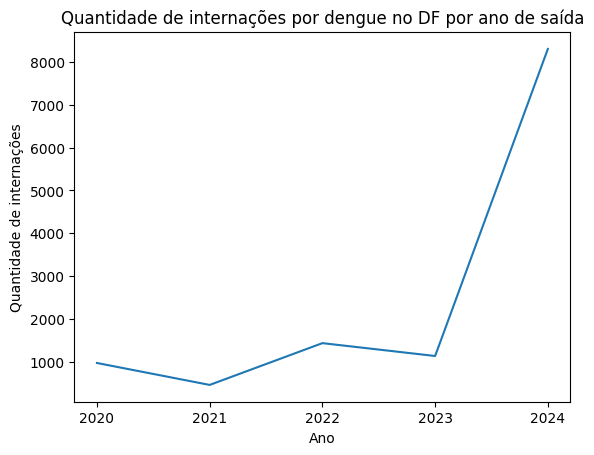

In [387]:
sns.lineplot(x='ano_saida', y='vl_total_count', data=agregado_ano)
plt.title('Quantidade de internações por dengue no DF por ano de saída')
plt.xticks(agregado_ano['ano_saida'])
plt.xlabel('Ano')
plt.ylabel('Quantidade de internações')
plt.show()

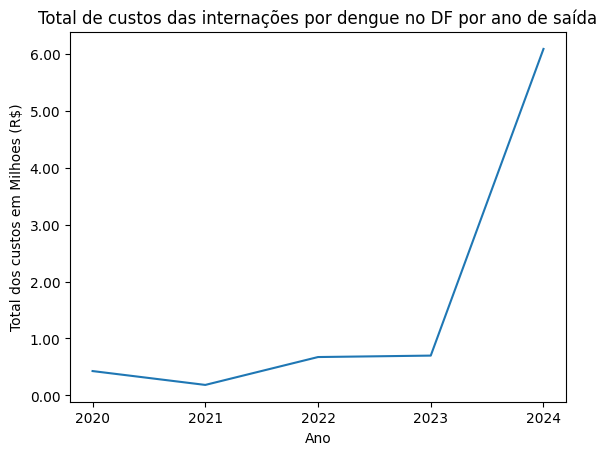

In [388]:
sns.lineplot(x='ano_saida', y='vl_total_sum', data=agregado_ano)
ax = plt.gca()

#Formata o eixo y para mostrar valores em milhões com 2 casas decimais
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))

plt.title('Total de custos das internações por dengue no DF por ano de saída')
plt.xticks(agregado_ano['ano_saida'])
plt.xlabel('Ano')
plt.ylabel('Total dos custos em Milhoes (R$)')
plt.show()

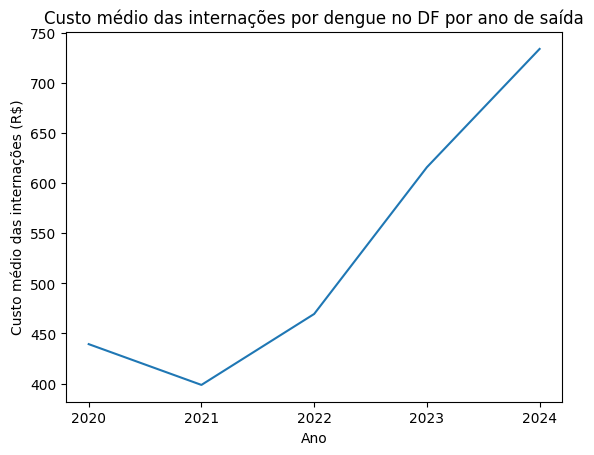

In [389]:
sns.lineplot(x='ano_saida', y='vl_total_mean', data=agregado_ano)
plt.title('Custo médio das internações por dengue no DF por ano de saída')
plt.xticks(agregado_ano['ano_saida'])
plt.xlabel('Ano')
plt.ylabel('Custo médio das internações (R$)')
plt.show()

In [390]:
agregado_ano_mes = agregar_dados(dengue_df, ['ano', 'mes'], ['vl_total'])
agregado_ano_mes

,ano,mes,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,2020,1,34,17797.33,287.76,5997.90,523.450882,971.375608
1,2020,2,116,37589.46,44.22,1026.86,324.047069,105.144701
2,2020,3,190,78395.76,44.22,6011.44,412.609263,551.906626
3,2020,4,226,87702.27,44.22,5913.54,388.063142,401.457493
4,2020,5,144,52664.36,44.22,1927.33,365.724722,228.909499
5,2020,6,86,67366.57,47.27,23613.34,783.332209,2733.024588
6,2020,7,47,17518.58,287.76,1389.23,372.735745,174.356281
7,2020,8,46,20546.13,287.76,3023.17,446.655000,415.711285
8,2020,9,30,9597.09,44.22,1667.74,319.903000,271.618387
9,2020,10,15,7479.93,287.76,2619.55,498.662000,597.982648


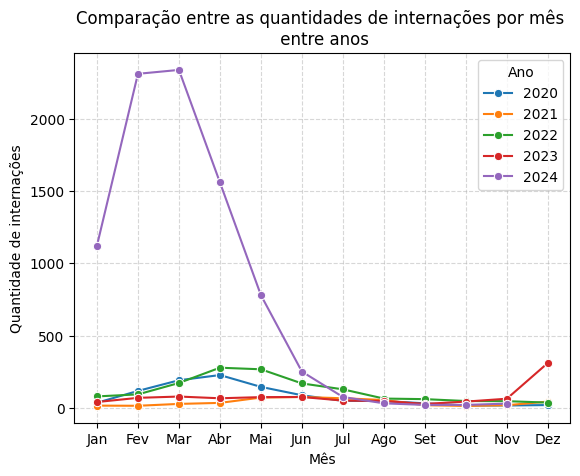

In [391]:
sns.lineplot(data=agregado_ano_mes, x="mes", y="vl_total_count", hue="ano", marker="o", palette="tab10")

plt.xticks(range(1, 13), ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])  # Meses formatados
plt.xlabel("Mês")
plt.ylabel("Quantidade de internações")
plt.title("Comparação entre as quantidades de internações por mês \n entre anos")
plt.legend(title="Ano")  # Ajusta legenda
plt.grid(True, linestyle="--", alpha=0.5)  # Adiciona grid suave

plt.show()

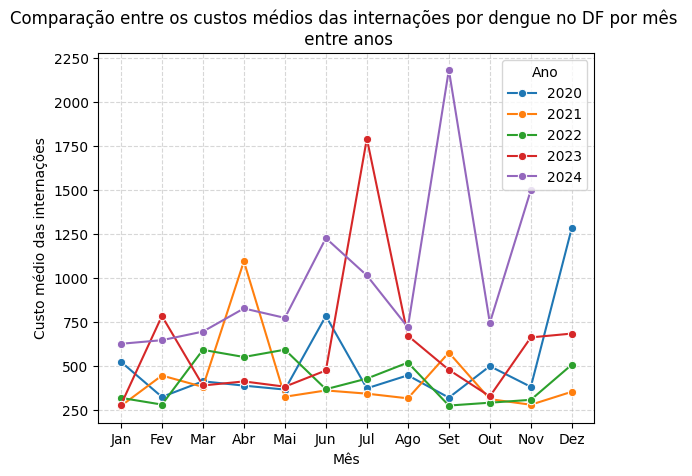

In [392]:
sns.lineplot(data=agregado_ano_mes, x="mes", y="vl_total_mean", hue="ano", marker="o", palette="tab10")

# Ajustes do gráfico
plt.xticks(range(1, 13), ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])  # Meses formatados
plt.xlabel("Mês")
plt.ylabel("Custo médio das internações")
plt.title("Comparação entre os custos médios das internações por dengue no DF por mês \n entre anos")
plt.legend(title="Ano")  # Ajusta legenda
plt.grid(True, linestyle="--", alpha=0.5)  # Adiciona grid suave

# Exibir gráfico
plt.show()

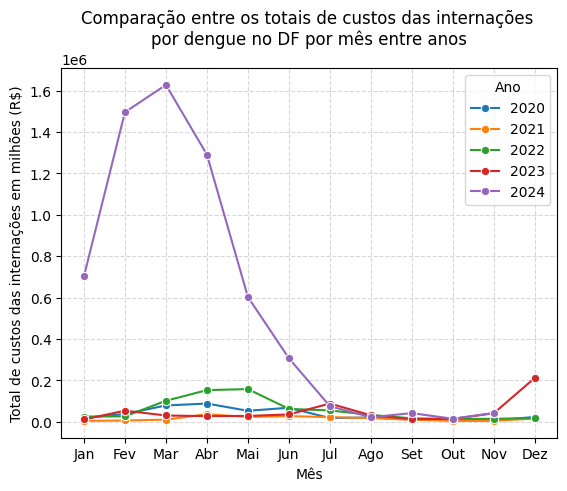

In [393]:
sns.lineplot(data=agregado_ano_mes, x="mes", y="vl_total_sum", hue="ano", marker="o", palette="tab10")

# Ajustes do gráfico
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))
plt.xticks(range(1, 13), ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])  # Meses formatados
plt.xlabel("Mês")
plt.ylabel("Total de custos das internações em milhões (R$)")
plt.title("Comparação entre os totais de custos das internações \npor dengue no DF por mês entre anos")
plt.legend(title="Ano")  # Ajusta legenda
plt.grid(True, linestyle="--", alpha=0.5)  # Adiciona grid suave

# Exibir gráfico
plt.show()

### Idade do paciente

In [394]:
unidades_idade = {
  "2": "Dias",
  "3": "Meses",
  "4": "Anos",
  "5": "Anos a partir de 100",
  "0": ""
}
dengue_df['unidade_idade']=dengue_df.cd_unidade_idade.replace(unidades_idade)
dengue_df.unidade_idade.value_counts()

,count
unidade_idade,
Anos,11667
Meses,577
Dias,56
Anos a partir de 100,3


In [395]:
import math

def calcula_idade_anos(cd_unidade_idade, idade):
  if cd_unidade_idade == '2':
    return float(idade)/365
  elif cd_unidade_idade == '3':
    return float(idade)/12
  elif cd_unidade_idade == '4':
    return float(idade)
  elif cd_unidade_idade == '5':
    return 100 + float(idade)

dengue_df['qt_idade_anos']=dengue_df[['cd_unidade_idade', 'qt_idade']].apply(lambda x: calcula_idade_anos(x.cd_unidade_idade, x.qt_idade), axis=1)
dengue_df['qt_idade_10_anos']=dengue_df[['cd_unidade_idade', 'qt_idade']].apply(lambda x: math.floor(calcula_idade_anos(x.cd_unidade_idade, x.qt_idade)/10)*10, axis=1)

In [396]:
dengue_df.qt_idade_10_anos.describe()

,qt_idade_10_anos
count,12303.000000
mean,25.529546
std,25.273862
min,0.000000
25%,0.000000
50%,20.000000
75%,50.000000
max,100.000000


In [397]:
agregado_idade_ano = agregar_dados(dengue_df, ['qt_idade_10_anos', 'ano'], ['vl_total'])
agregado_idade_ano.head()

,qt_idade_10_anos,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,0,2020,301,119243.87,47.27,6011.44,396.159037,543.766621
1,0,2021,157,54702.65,47.27,2648.13,348.424522,269.247658
2,0,2022,523,154168.89,47.27,6543.69,294.777992,338.293615
3,0,2023,349,137049.86,47.27,8611.27,392.693009,873.615281
4,0,2024,2494,1193345.65,44.22,23043.92,478.486628,1069.424202


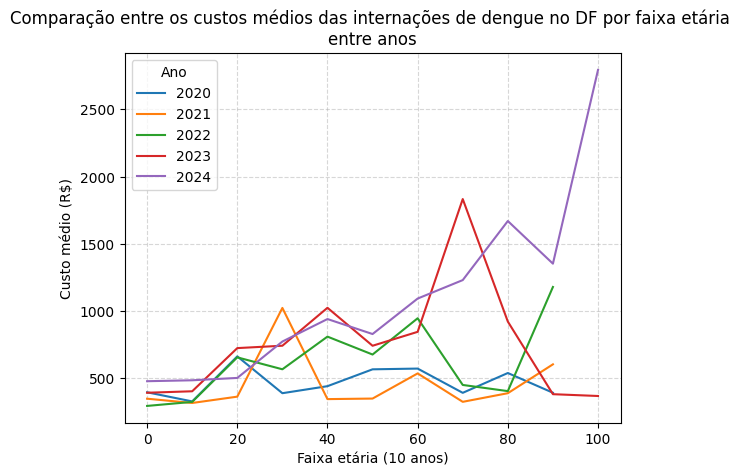

In [398]:
sns.lineplot(data=agregado_idade_ano, x="qt_idade_10_anos", y="vl_total_mean", hue="ano", palette="tab10")

plt.xlabel("Faixa etária (10 anos)")
plt.ylabel("Custo médio (R$)")
plt.title("Comparação entre os custos médios das internações de dengue no DF por faixa etária \nentre anos")
plt.legend(title="Ano")  # Ajusta legenda
plt.grid(True, linestyle="--", alpha=0.5)  # Adiciona grid suave

plt.show()

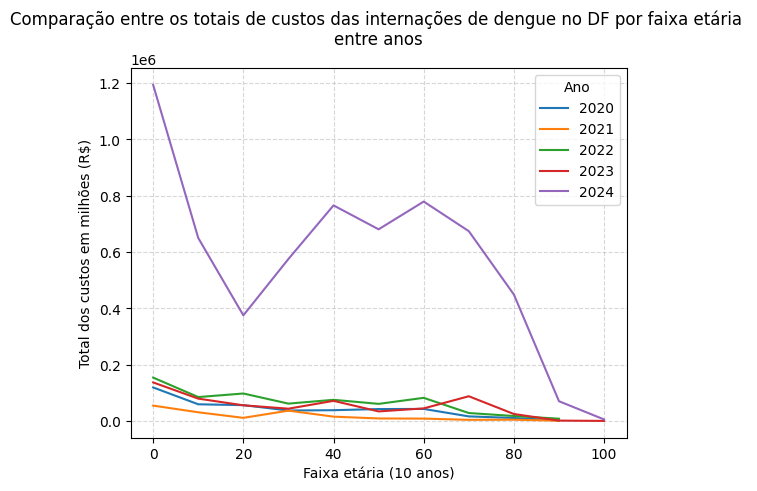

In [399]:
sns.lineplot(data=agregado_idade_ano, x="qt_idade_10_anos", y="vl_total_sum", hue="ano", palette="tab10")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))
plt.xlabel("Faixa etária (10 anos)")
plt.ylabel("Total dos custos em milhões (R$)")
plt.title("Comparação entre os totais de custos das internações de dengue no DF por faixa etária \nentre anos")
plt.legend(title="Ano")  # Ajusta legenda
plt.grid(True, linestyle="--", alpha=0.5)  # Adiciona grid suave

plt.show()

### Diagnósticos secundários

In [400]:
dengue_df["qt_diag_sec"] = (
    dengue_df["cd_diag_sec_1"].str.strip().apply(lambda x: 0 if len(x) == 0 else 1) +
    dengue_df["cd_diag_sec_2"].str.strip().apply(lambda x: 0 if len(x) == 0 else 1) +
    dengue_df["cd_diag_sec_3"].str.strip().apply(lambda x: 0 if len(x) == 0 else 1) +
    dengue_df["cd_diag_sec_4"].str.strip().apply(lambda x: 0 if len(x) == 0 else 1) +
    dengue_df["cd_diag_sec_5"].str.strip().apply(lambda x: 0 if len(x) == 0 else 1)
  )

In [401]:
agregado_diag_sec_ano = agregar_dados(dengue_df, ['qt_diag_sec', 'ano'], ['vl_total'])
agregado_diag_sec_ano

,qt_diag_sec,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,0,2020,939,388445.12,44.22,7976.86,413.679574,628.667249
1,0,2021,419,150119.41,44.22,4562.36,358.280215,334.960211
2,0,2022,1368,641004.35,40.38,34135.46,468.570431,1442.150827
3,0,2023,902,563630.48,40.38,34453.25,624.867494,1879.065538
4,0,2024,8268,5782106.82,40.38,54701.14,699.335610,2325.375611
5,1,2020,25,11830.55,55.27,1722.64,473.222000,299.141397
6,1,2021,11,23572.45,47.27,19017.10,2142.950000,5605.295773
7,1,2022,44,23590.67,47.27,3915.43,536.151591,574.156861
8,1,2023,25,12210.46,55.27,1785.30,488.418400,381.244032
9,1,2024,226,281964.86,44.22,25438.87,1247.632124,2998.129683


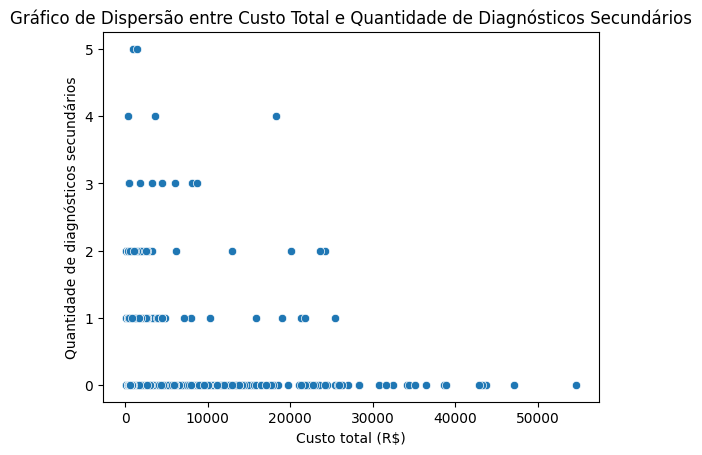

In [402]:
sns.scatterplot(data=dengue_df, x="vl_total", y="qt_diag_sec")
plt.title("Gráfico de Dispersão entre Custo Total e Quantidade de Diagnósticos Secundários")
plt.xlabel("Custo total (R$)")
plt.ylabel("Quantidade de diagnósticos secundários")
plt.show()

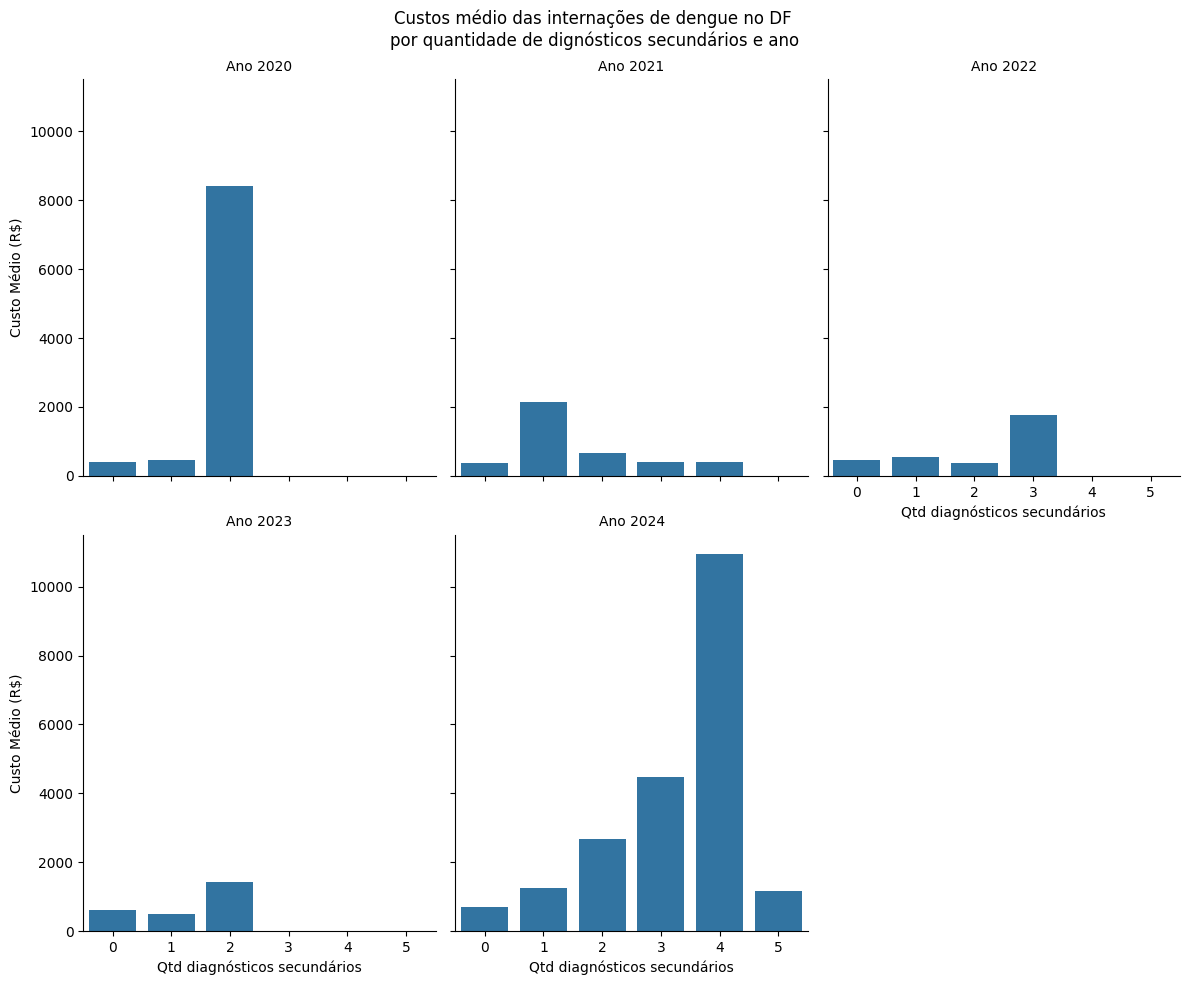

In [403]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_diag_sec_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "qt_diag_sec", "vl_total_mean", order=agregado_diag_sec_ano["qt_diag_sec"].unique())

g.set_axis_labels("Qtd diagnósticos secundários", "Custo Médio (R$)")

# Ajustar os títulos
plt.suptitle("Custos médio das internações de dengue no DF \npor quantidade de dignósticos secundários e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Diárias de UTI

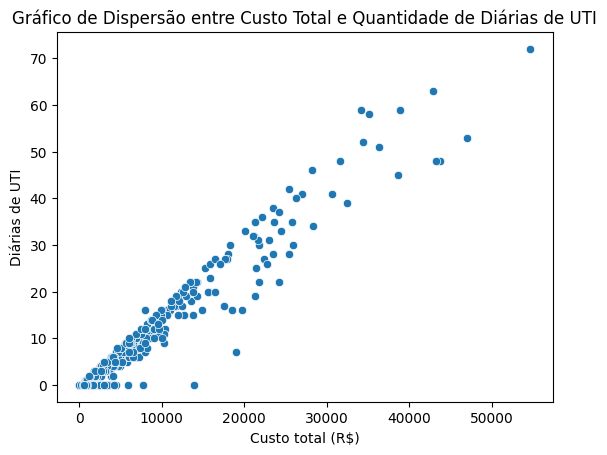

In [404]:
sns.scatterplot(data=dengue_df, x="vl_total", y="qt_diarias_uti")
plt.title("Gráfico de Dispersão entre Custo Total e Quantidade de Diárias de UTI")
plt.xlabel("Custo total (R$)")
plt.ylabel("Diárias de UTI")
plt.show()

### Dias de permanência

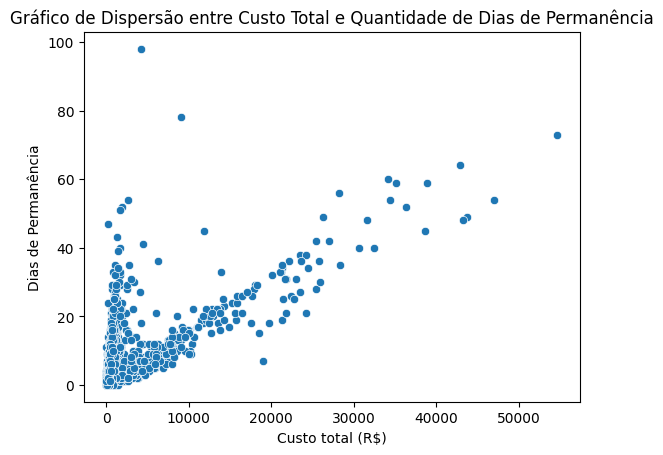

In [405]:
sns.scatterplot(data=dengue_df, x="vl_total", y="qt_dias_permanencia")
plt.title("Gráfico de Dispersão entre Custo Total e Quantidade de Dias de Permanência")
plt.xlabel("Custo total (R$)")
plt.ylabel("Dias de Permanência")
plt.show()

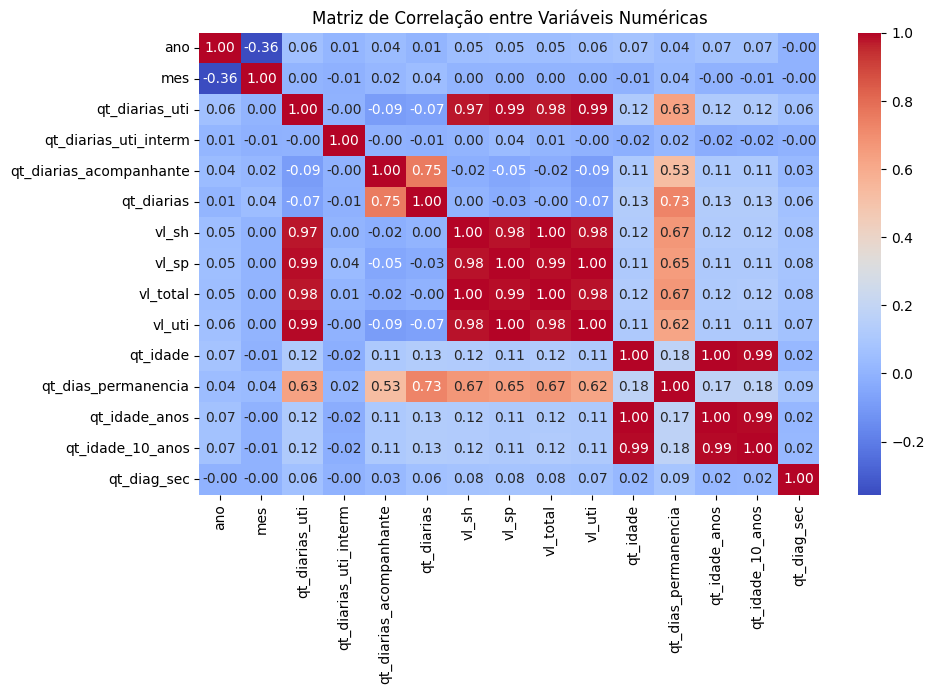

In [406]:
# Matriz de correlação para variáveis numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(dengue_df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

## Tratamento de variáveis categóricas

### Especialidades de leitos

In [407]:
especialidades = {
  '01': 'Cirurgia',
  '02': 'Obstetrícia',
  '03': 'Clínica médica',
  '04': 'Crônicos',
  '05': 'Psiquiatria',
  '06': 'Pneumologia sanitária',
  '07': 'Pediatria',
  '08': 'Reabilitação',
  '09': 'Hospital dia (cirúrgicos)',
  '10': 'Hospital dia (AIDS)',
  '11': 'Hospital dia (fibrose cística)',
  '12': 'Hospital dia (intercorrência pós transplantes)',
  '13': 'Hospital dia (geriatria)',
  '14': 'Hospital dia (saúde mental)'
}

dengue_df['especialidade']=dengue_df.cd_especialidade.replace(especialidades)


agregado_especialidade_ano = agregar_dados(dengue_df, ['especialidade', 'ano'], ['vl_total'])

agregado_especialidade_ano


,especialidade,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,Cirurgia,2022,1,5141.61,5141.61,5141.61,5141.610000,NaN
1,Cirurgia,2024,5,29231.12,729.09,12691.88,5846.224000,5454.113063
2,Clínica médica,2020,555,269707.24,44.22,23613.34,485.958991,1215.229368
3,Clínica médica,2021,216,102462.16,44.22,19017.10,474.361852,1332.842846
4,Clínica médica,2022,717,454582.61,40.38,34135.46,634.006430,1947.742936
5,Clínica médica,2023,441,389839.92,40.38,34453.25,883.990748,2524.486598
6,Clínica médica,2024,5002,4576809.73,40.38,54701.14,914.995948,2987.678725
7,Pediatria,2020,412,155775.90,47.27,6011.44,378.096845,468.030874
8,Pediatria,2021,220,74708.17,47.27,2648.13,339.582591,234.008386
9,Pediatria,2022,709,212062.32,47.27,6543.69,299.100592,338.971197


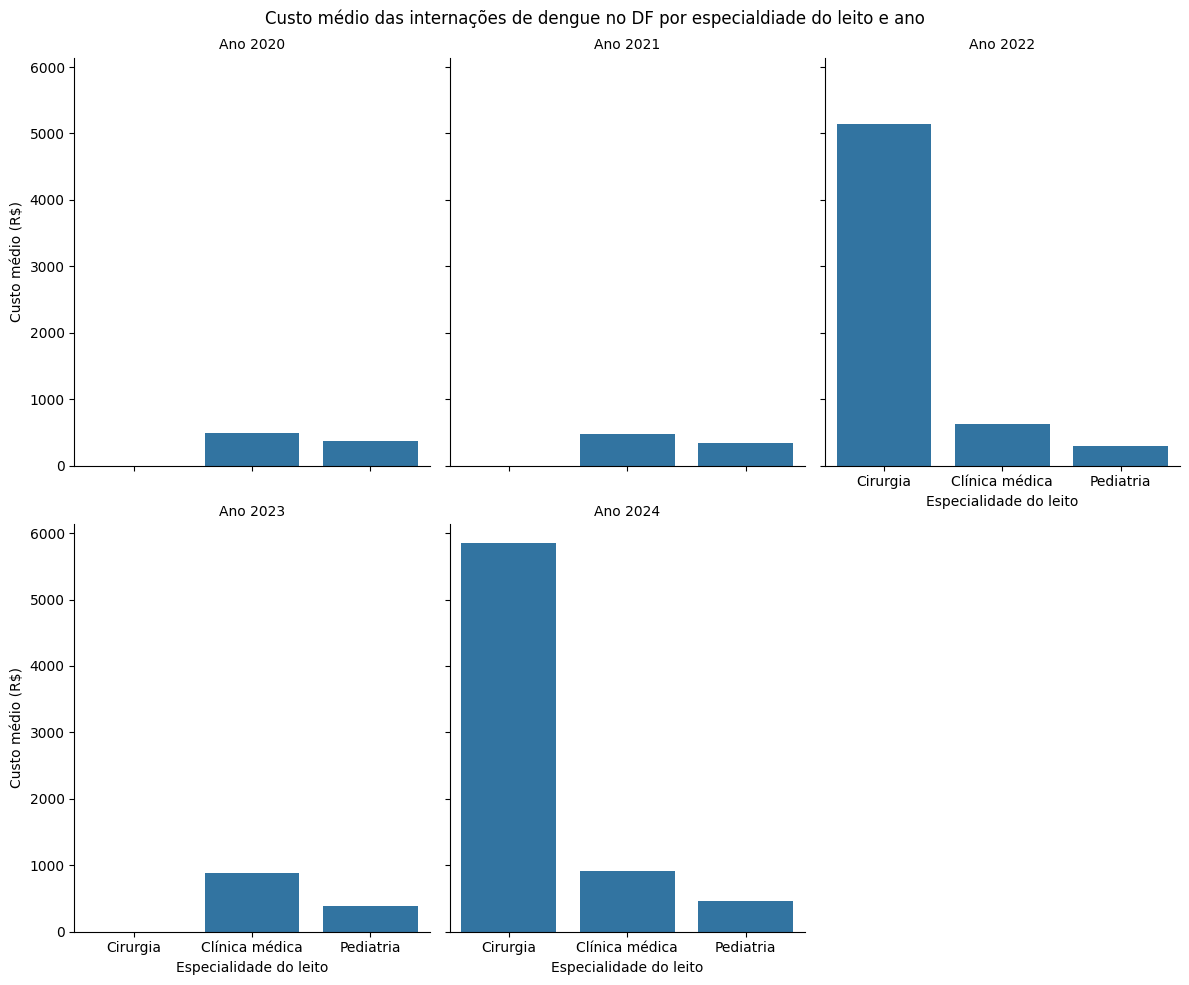

In [408]:

# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_especialidade_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "especialidade", "vl_total_mean", order=agregado_especialidade_ano["especialidade"].unique())

g.set_axis_labels("Especialidade do leito", "Custo médio (R$)")

# Ajustar os títulos
plt.suptitle("Custo médio das internações de dengue no DF por especialdiade do leito e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()


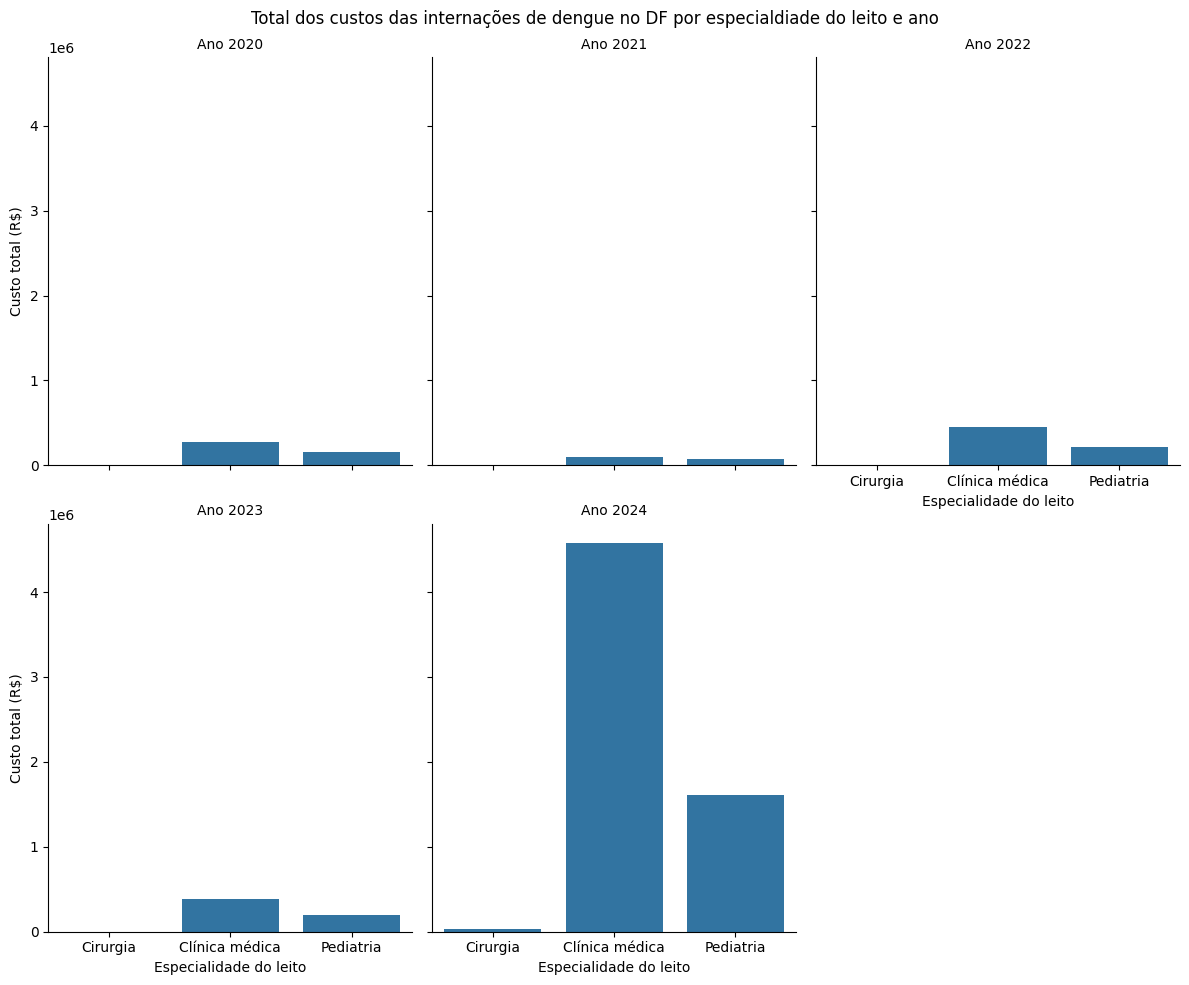

In [409]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_especialidade_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "especialidade", "vl_total_sum", order=agregado_especialidade_ano["especialidade"].unique())

g.set_axis_labels("Especialidade do leito", "Custo total (R$)")

# Ajustar os títulos
plt.suptitle("Total dos custos das internações de dengue no DF por especialdiade do leito e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Sexo do paciente

In [410]:
sexos = {
  '1': 'Masculino',
  '2': 'Feminino',
  '3': 'Feminino',
  '0': 'NA',
  '9': 'NA'
}
dengue_df['sexo']=dengue_df.cd_sexo.replace(sexos)

agregado_sexo_ano = agregar_dados(dengue_df, ['sexo', 'ano'], ['vl_total'])

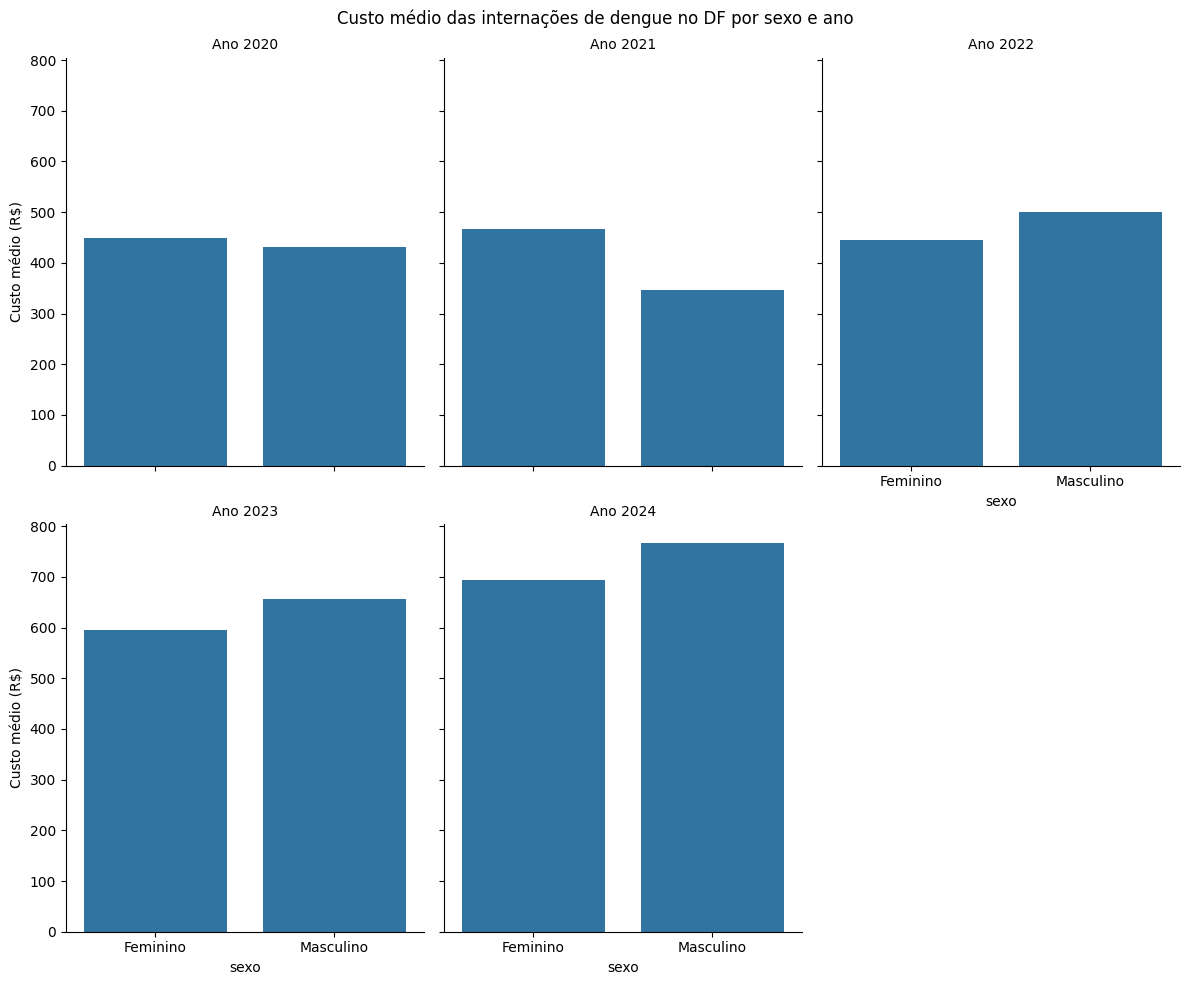

In [411]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_sexo_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "sexo", "vl_total_mean", order=agregado_sexo_ano["sexo"].unique())

g.set_axis_labels("sexo", "Custo médio (R$)")

# Ajustar os títulos
plt.suptitle("Custo médio das internações de dengue no DF por sexo e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Tipos de UTI

In [412]:
tipos_utis = {
  '00': 'Não utilizou UTI',
  '51': 'UTI II Adulto Covid-19',
  '52': 'UTI II Pediátrica Covid-19',
  '74': 'UTI I adulto',
  '75': 'UTI II adulto',
  '76': 'UTI III adulto',
  '77': 'UTI I infantil',
  '78': 'UTI II infantil',
  '79': 'UTI III infantil',
  '80': 'UTI I neonatal',
  '81': 'UTI II neonatal',
  '82': 'UTI III neonatal',
  '83': 'UTI queimados',
  '85': 'UTI II coronariana',
  '86': 'UTI III coronariana',
  '99': 'UTI Doador',
  '01': '+ de 1 tipo de UTI'
}

dengue_df['tipo_uti']=dengue_df.cd_tipo_uti.replace(tipos_utis)
agregado_tp_uti_ano = agregar_dados(dengue_df, ['tipo_uti', 'ano'], ['vl_total'])
agregado_tp_uti_ano

,tipo_uti,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,+ de 1 tipo de UTI,2024,1,24193.83,24193.83,24193.83,24193.830000,NaN
1,Não utilizou UTI,2020,954,350152.53,44.22,7789.82,367.036195,342.417363
2,Não utilizou UTI,2021,430,145153.49,44.22,2985.90,337.566256,205.804994
3,Não utilizou UTI,2022,1390,452012.82,40.38,13954.59,325.189079,438.903992
4,Não utilizou UTI,2023,871,287985.50,40.38,2760.44,330.637773,242.646798
5,Não utilizou UTI,2024,7942,2618987.25,40.38,4235.37,329.764197,214.177069
6,UTI II Adulto Covid-19,2021,1,19017.10,19017.10,19017.10,19017.100000,NaN
7,UTI II adulto,2020,8,59297.94,1310.11,23613.34,7412.242500,7088.509796
8,UTI II adulto,2021,2,6315.51,1753.15,4562.36,3157.755000,1986.411441
9,UTI II adulto,2022,30,179345.77,887.76,34135.46,5978.192333,6463.582328


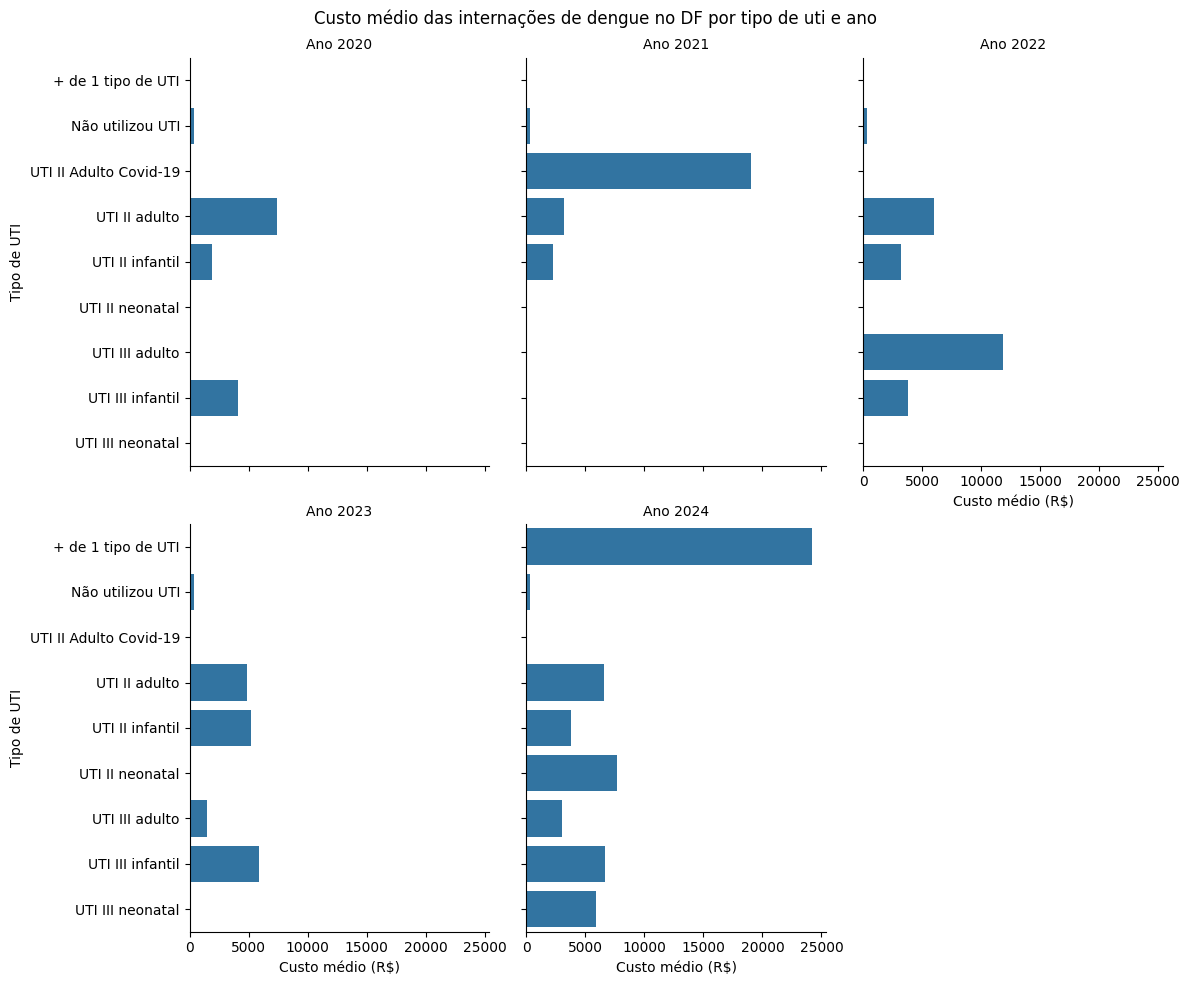

In [413]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_tp_uti_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "vl_total_mean", "tipo_uti", order=agregado_tp_uti_ano["tipo_uti"].unique())

g.set_axis_labels("Custo médio (R$)", "Tipo de UTI")

# Ajustar os títulos
plt.suptitle("Custo médio das internações de dengue no DF por tipo de uti e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

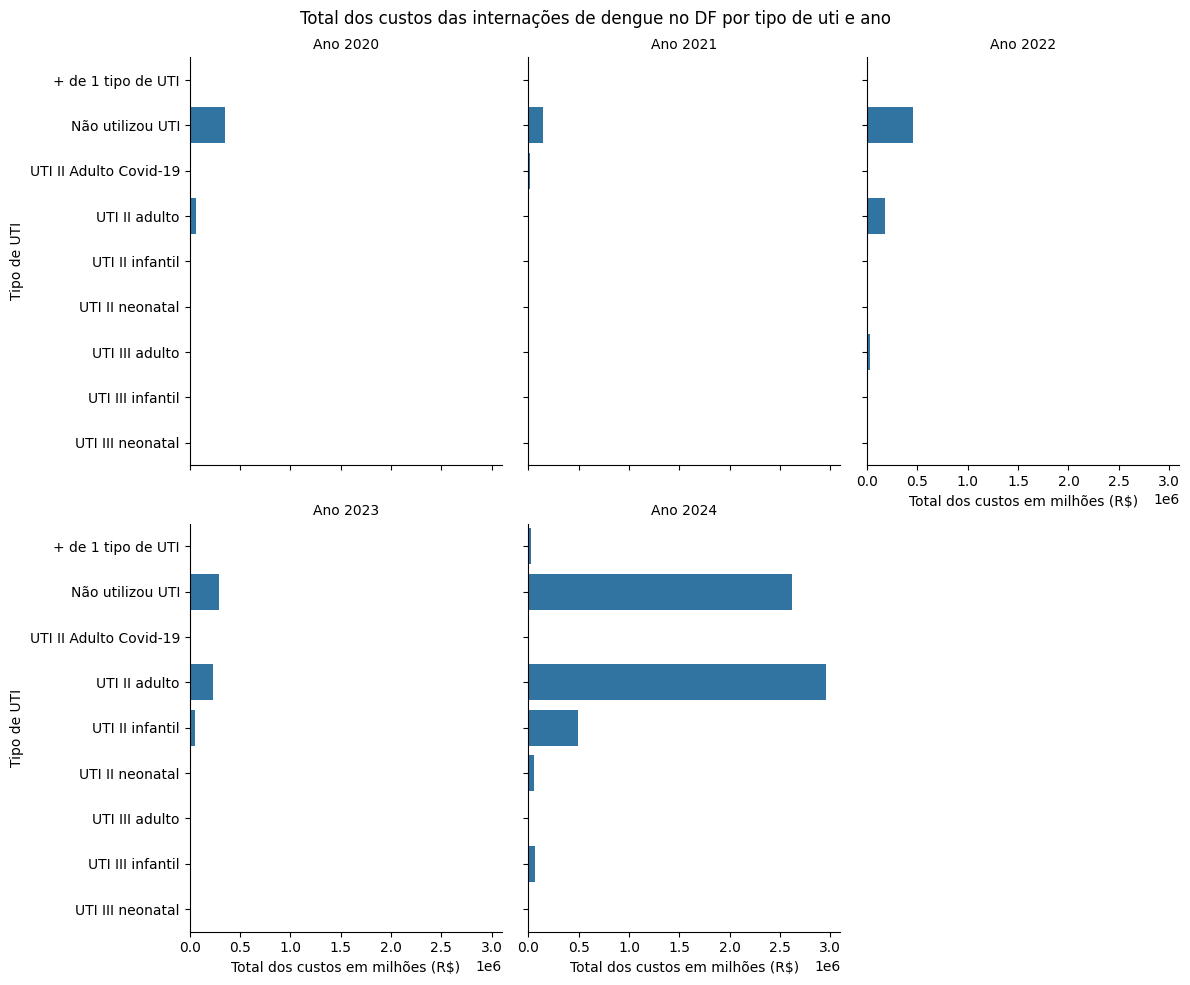

In [414]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_tp_uti_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "vl_total_sum", "tipo_uti", order=agregado_tp_uti_ano["tipo_uti"].unique())

g.set_axis_labels("Total dos custos em milhões (R$)", "Tipo de UTI")

# Ajustar os títulos
plt.suptitle("Total dos custos das internações de dengue no DF por tipo de uti e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Motivo de alta/permanência

In [415]:
motivos_alta_perm = {
  '11': 'Alta curado',
  '12': 'Alta melhorado',
  '14': 'Alta a pedido',
  '15': 'Alta com previsão de retorno p/acomp do paciente',
  '16': 'Alta por evasão',
  '18': 'Alta por outros motivos',
  '19': 'Alta de paciente agudo em psiquiatria',
  '21': 'Permanência por características próprias da doença',
  '22': 'Permanência por intercorrência',
  '23': 'Permanência por impossibilidade sócio-familiar',
  '24': 'Permanência proc doação órg, tec, cél-doador vivo',
  '25': 'Permanência proc doação órg, tec, cél-doador morto',
  '26': 'Permanência por mudança de procedimento',
  '27': 'Permanência por reoperação',
  '28': 'Permanência por outros motivos',
  '29': 'Transferência para internação domiciliar',
  '32': 'Transferência para internação domiciliar',
  '31': 'Transferência para outro estabelecimento',
  '41': 'Óbito com DO fornecida pelo médico assistente',
  '42': 'Óbito com DO fornecida pelo IML',
  '43': 'Óbito com DO fornecida pelo SVO',
  '51': 'Encerramento administrativo',
  '61': 'Alta da mãe/puérpera e do recém-nascido',
  '17': 'Alta da mãe/puérpera e do recém-nascido',
  '62': 'Alta da mãe/puérpera e permanência recém-nascido',
  '13': 'Alta da mãe/puérpera e permanência recém-nascido',
  '63': 'Alta da mãe/puérpera e óbito do recém-nascido',
  '64': 'Alta da mãe/puérpera com óbito fetal',
  '65': 'Óbito da gestante e do concepto',
  '66': 'Óbito da mãe/puérpera e alta do recém-nascido',
  '67': 'Óbito da mãe/puérpera e permanência recém-nascido'
}

dengue_df['motivo_alta_perm']=dengue_df.cd_motivo_alta_perm.replace(motivos_alta_perm)
dengue_df.motivo_alta_perm.value_counts()

,count
motivo_alta_perm,
Alta melhorado,8781
Alta com previsão de retorno p/acomp do paciente,1752
Transferência para outro estabelecimento,699
Alta por outros motivos,280
Alta por evasão,264
Óbito com DO fornecida pelo médico assistente,142
Permanência por mudança de procedimento,107
Alta curado,72
Permanência por intercorrência,56


### Natureza jurídica do hospital

In [416]:
naturezas_juridicas = {
  '1015':"Órgão Público do Poder Executivo Federal",
  '1023':"Órgão Público do Poder Exec Estadual ou Distr Fed",
  '1031':"Órgão Público do Poder Executivo Municipal",
  '1040':"Órgão Público do Poder Legislativo Federal",
  '1058':"Órgão Público do Poder Legisl Estadual ou Dist Fed",
  '1066':"Órgão Público do Poder Legislativo Municipal",
  '1074':"Órgão Público do Poder Judiciário Federal",
  '1082':"Órgão Público do Poder Judiciário Estadual",
  '1104':"Autarquia Federal",
  '1112':"Autarquia Estadual ou do Distrito Federal",
  '1120':"Autarquia Municipal",
  '1139':"Fundação Federal",
  '1147':"Fundação Estadual ou do Distrito Federal",
  '1155':"Fundação Municipal",
  '1163':"Órgão Público Autônomo Federal",
  '1171':"Órgão Público Autônomo Estadual ou Distr Federal",
  '1180':"Órgão Público Autônomo Estadual ou Distr Federal",
  '1198':"Comissão Polinacional",
  '1201':"Fundo Público",
  '1210':"Associação Pública",
  '2011':"Empresa Pública",
  '2038':"Sociedade de Economia Mista",
  '2046':"Sociedade Anônima Aberta",
  '2054':"Sociedade Anônima Fechada",
  '2062':"Sociedade Empresária Limitada",
  '2070':"Sociedade Empresária em Nome Coletivo",
  '2089':"Sociedade Empresária em Comandita Simples",
  '2097':"Sociedade Empresária em Comandita por Ações",
  '2127':"Sociedade em Conta de Participação",
  '2135':"Empresário (Individual)",
  '2143':"Cooperativa",
  '2151':"Consórcio de Sociedades",
  '2160':"Grupo de Sociedades",
  '2178':"Estabelecimento no Brasil de Sociedade Estrangeira",
  '2194':"Estab no Brasil Empr Binacional Argentina-Brasil",
  '2216':"Empresa Domiciliada no Exterior",
  '2224':"Clube/Fundo de Investimento",
  '2232':"Sociedade Simples Pura",
  '2240':"Sociedade Simples Limitada",
  '2259':"Sociedade Simples em Nome Coletivo",
  '2267':"Sociedade Simples em Comandita Simples",
  '2275':"Empresa Binacional",
  '2283':"Consórcio de Empregadores",
  '2291':"Consórcio Simples",
  '2305':"Empr Individ Responsab Limitada (Natur Empresária)",
  '2313':"Empr Individ Responsab Limitada (Natureza Simples)",
  '3034':"Serviço Notarial e Registral (Cartório)",
  '3069':"Fundação Privada",
  '3077':"Serviço Social Autônomo",
  '3085':"Condomínio Edilício",
  '3107':"Comissão de Conciliação Prévia",
  '3115':"Entidade de Mediação e Arbitragem",
  '3123':"Partido Político",
  '3131':"Entidade Sindical",
  '3204':"Estab no Brasil de Fundação ou Associação Estrang",
  '3212':"Fundação ou Associação Domiciliada no Exterior",
  '3220':"Organização Religiosa",
  '3239':"Comunidade Indígena",
  '3247':"Fundo Privado",
  '3999':"Associação Privada",
  '4014':"Empresa Individual Imobiliária",
  '4022':"Segurado Especial",
  '4081':"Contribuinte Individual",
  '4090':"Candidato a Cargo Político Eletivo",
  '4111':"Leiloeiro",
  '5010':"Organização Internacional",
  '5029':"Representação Diplomática Estrangeira",
  '5037':"Outras Instituições Extraterritoriais",
  '0000':""
}

dengue_df['natureza_juridica']=dengue_df.cd_natureza_juridica.replace(naturezas_juridicas)

agregado_nat_jur_ano = agregar_dados(dengue_df, ['natureza_juridica', 'ano'], ['vl_total'])
agregado_nat_jur_ano

,natureza_juridica,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,Associação Privada,2020,1,7508.14,7508.14,7508.14,7508.140000,NaN
1,Associação Privada,2022,3,46636.06,6154.37,34135.46,15545.353333,16099.790433
2,Associação Privada,2023,7,25679.73,368.99,10971.17,3668.532857,3612.130137
3,Associação Privada,2024,73,517159.45,927.27,47078.63,7084.376027,9498.265289
4,Fundação Estadual ou do Distrito Federal,2020,61,26432.51,289.17,1389.23,433.319836,174.372061
5,Fundação Estadual ou do Distrito Federal,2021,55,21137.82,289.17,510.22,384.324000,38.336830
6,Fundação Federal,2020,16,16244.17,305.17,7976.86,1015.260625,1870.891267
7,Fundação Federal,2021,9,3447.61,295.76,537.79,383.067778,79.630638
8,Fundação Federal,2022,31,16827.66,170.30,3573.33,542.827742,622.999043
9,Fundação Federal,2023,11,28186.34,354.90,23536.54,2562.394545,6957.995951


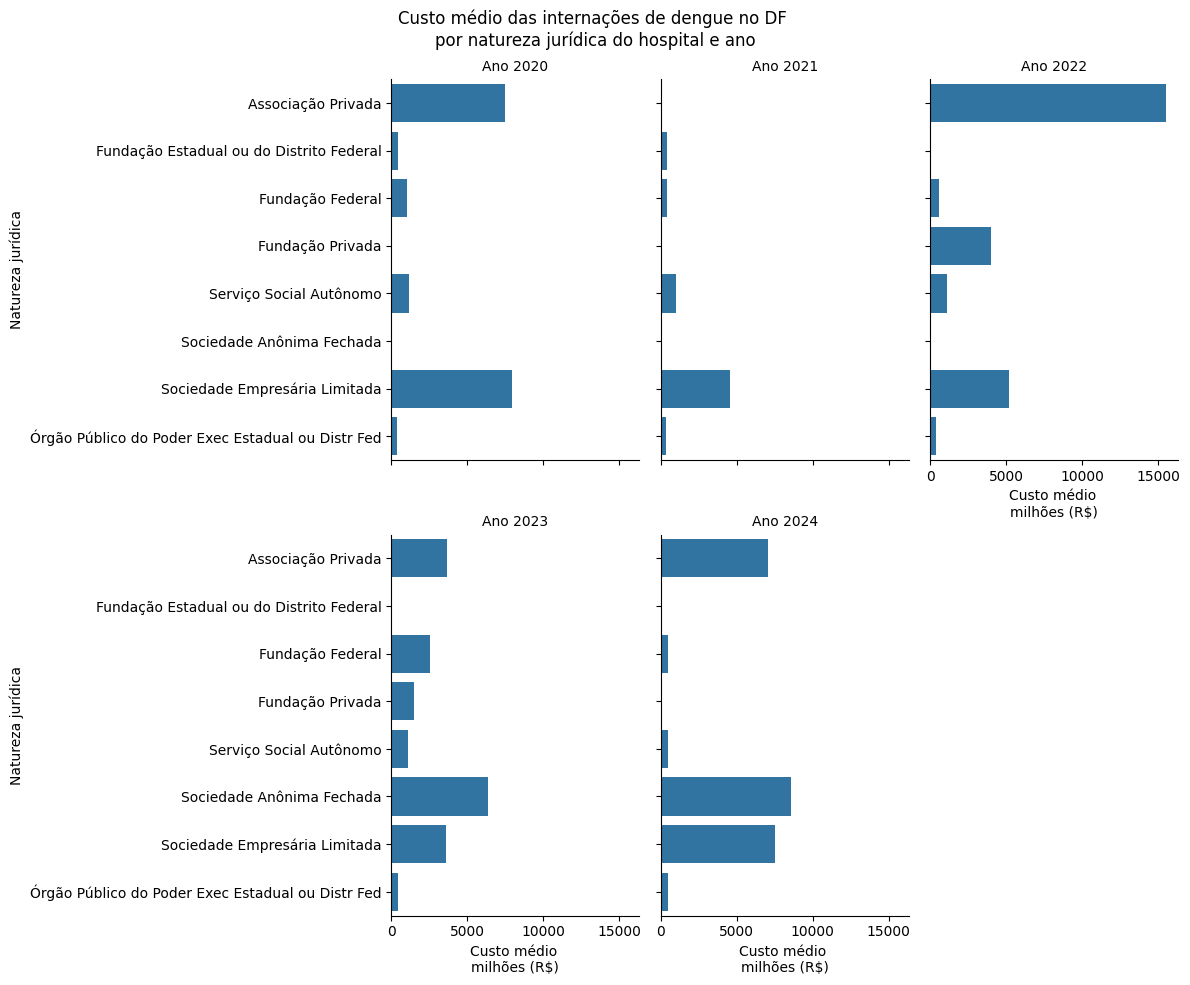

In [417]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_nat_jur_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "vl_total_mean", "natureza_juridica", order=agregado_nat_jur_ano["natureza_juridica"].unique())

g.set_axis_labels("Custo médio \nmilhões (R$)", "Natureza jurídica")

# Ajustar os títulos
plt.suptitle("Custo médio das internações de dengue no DF \npor natureza jurídica do hospital e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

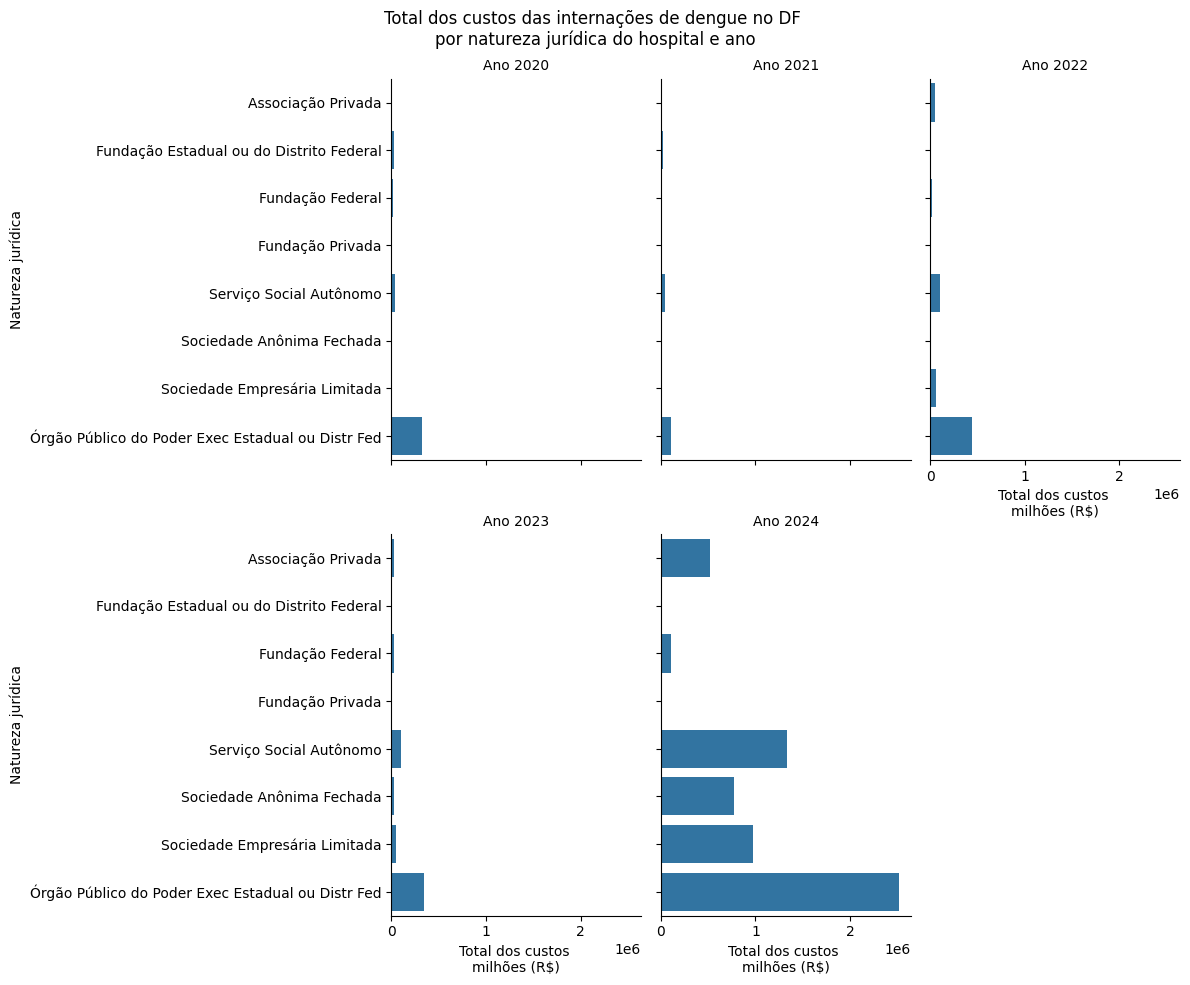

In [418]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_nat_jur_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "vl_total_sum", "natureza_juridica", order=agregado_nat_jur_ano["natureza_juridica"].unique())

g.set_axis_labels("Total dos custos \nmilhões (R$)", "Natureza jurídica")

# Ajustar os títulos
plt.suptitle("Total dos custos das internações de dengue no DF \npor natureza jurídica do hospital e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Morte

In [419]:
morte = {
  '0': "Não",
  '1': "Sim"
}
dengue_df['morte']=dengue_df.cd_morte.replace(morte)

agregado_morte_ano = agregar_dados(dengue_df, ['morte', 'ano'], ['vl_total'])
agregado_morte_ano

,morte,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,Não,2020,962,413472.61,44.22,23613.34,429.805208,938.984783
1,Não,2021,435,158153.23,44.22,4562.36,363.570644,335.177423
2,Não,2022,1413,632587.26,40.38,34135.46,447.690913,1371.466538
3,Não,2023,920,549862.67,40.38,34453.25,597.676815,1800.300965
4,Não,2024,8401,5532257.49,40.38,43300.35,658.523686,2055.012232
5,Sim,2020,5,12010.53,287.76,7976.86,2402.106000,3326.543630
6,Sim,2021,1,19017.10,19017.10,19017.10,19017.100000,NaN
7,Sim,2022,14,39199.28,295.76,10435.25,2799.948571,3124.277756
8,Sim,2023,11,31670.46,290.17,13560.51,2879.132727,3911.082702
9,Sim,2024,141,686046.89,44.22,54701.14,4865.580780,8651.657750


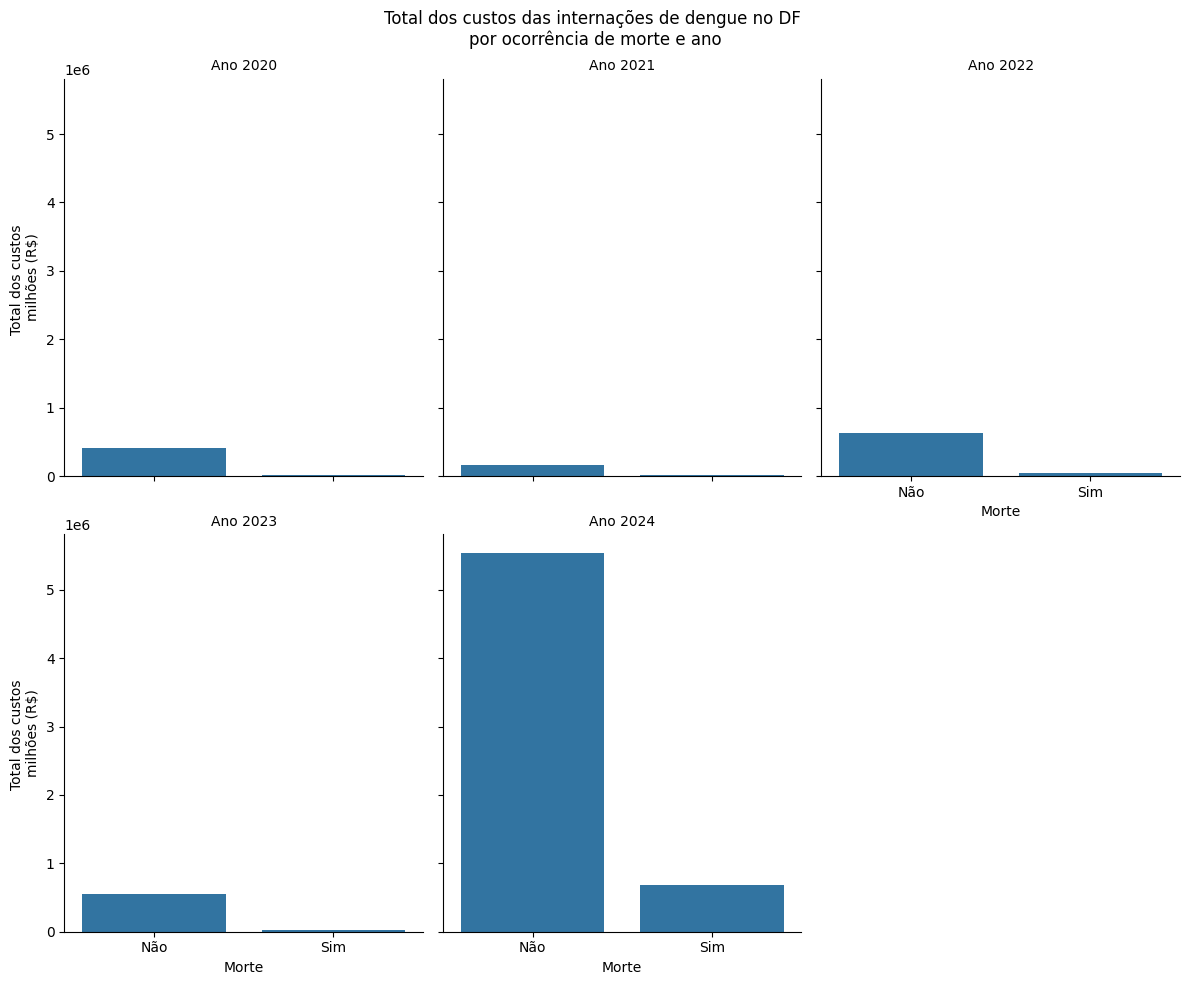

In [420]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_morte_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "morte", "vl_total_sum", order=agregado_morte_ano["morte"].unique())

g.set_axis_labels("Morte", "Total dos custos \nmilhões (R$)")

# Ajustar os títulos
plt.suptitle("Total dos custos das internações de dengue no DF \npor ocorrência de morte e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

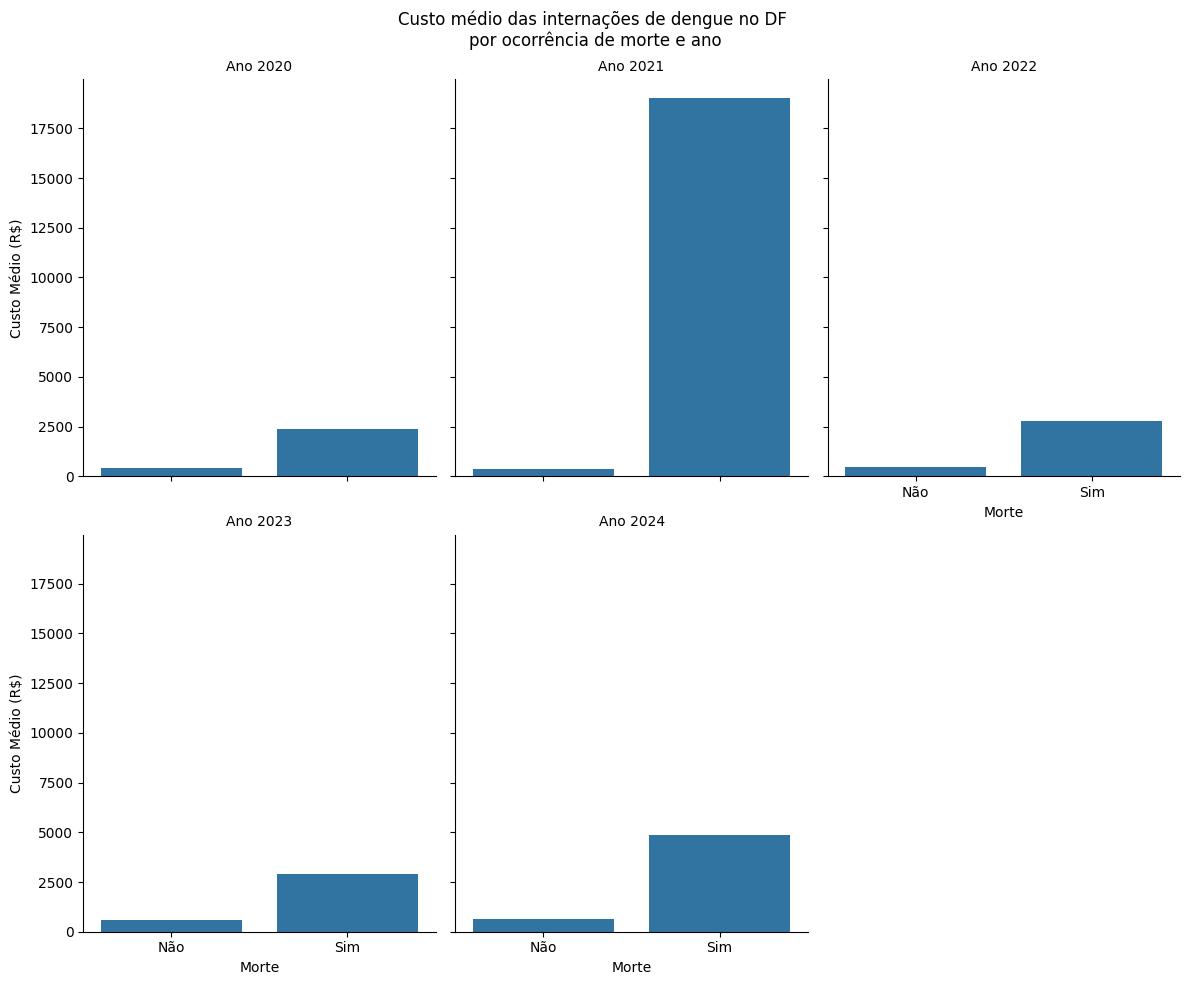

In [421]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_morte_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "morte", "vl_total_mean", order=agregado_morte_ano["morte"].unique())

g.set_axis_labels("Morte", "Custo Médio (R$)")

# Ajustar os títulos
plt.suptitle("Custo médio das internações de dengue no DF \npor ocorrência de morte e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Caráter do atendimento

In [422]:
carateres_atedimento = {
  '01': 'Eletivo',
  '02': 'Urgência',
  '03': 'Acidente no local trabalho ou a serv da empresa',
  '04': 'Acidente no trajeto para o trabalho',
  '05': 'Outros tipo de acidente de trânsito',
  '06': 'Outros tipos de lesões'
}
dengue_df['carater_atendimento']=dengue_df.cd_carater_atendimento.replace(carateres_atedimento)
dengue_df.carater_atendimento.value_counts()

,count
carater_atendimento,
Urgência,12139
Eletivo,164


### Complexidade

In [423]:
complexidades = {
  '01': 'Atenção básica',
  '02': 'Média complexidade',
  '03': 'Alta complexidade'
}
dengue_df['complexidade']=dengue_df.cd_complexidade.replace(complexidades)
dengue_df.complexidade.value_counts()

,count
complexidade,
Média complexidade,12291
Alta complexidade,12


### Raça/cor

In [424]:
racas_cores = {
  '01': 'Branca',
  '02': 'Preta',
  '03': 'Parda',
  '04': 'Amarela',
  '05': 'Indígena',
  '00': 'NA',
  '99': 'NA'
}
dengue_df['raca_cor']=dengue_df.cd_raca_cor.replace(racas_cores)
agregado_cor_ano = agregar_dados(dengue_df, ['raca_cor', 'ano'], ['vl_total'])
agregado_cor_ano

,raca_cor,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,Amarela,2020,3,1050.14,287.76,388.47,350.046667,54.430874
1,Amarela,2021,1,364.50,364.50,364.50,364.500000,NaN
2,Amarela,2022,5,1473.15,55.27,604.92,294.630000,207.792392
3,Amarela,2023,8,3164.96,295.76,583.24,395.620000,89.326675
4,Amarela,2024,64,101407.03,44.22,22364.73,1584.484844,4192.041738
5,Branca,2020,125,46445.23,47.27,5997.90,371.561840,516.381614
6,Branca,2021,73,24858.16,44.22,2985.90,340.522740,342.403751
7,Branca,2022,234,76109.12,44.22,6154.37,325.252650,519.984942
8,Branca,2023,258,168984.63,44.22,23536.54,654.979186,1948.535371
9,Branca,2024,1745,1071631.58,44.22,43763.46,614.115519,1875.469107


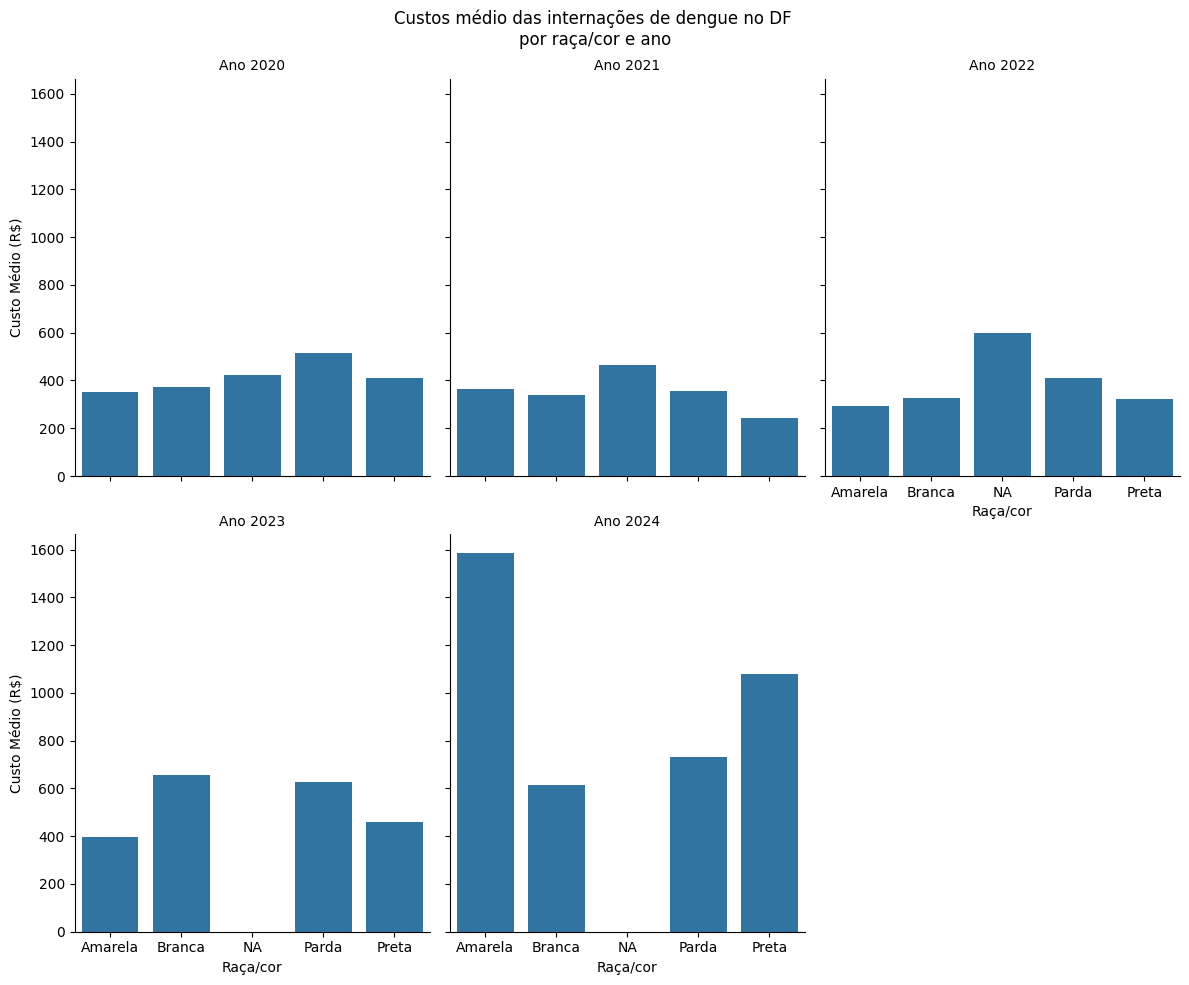

In [425]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_cor_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "raca_cor", "vl_total_mean", order=agregado_cor_ano["raca_cor"].unique())

g.set_axis_labels("Raça/cor", "Custo Médio (R$)")

# Ajustar os títulos
plt.suptitle("Custos médio das internações de dengue no DF \npor raça/cor e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

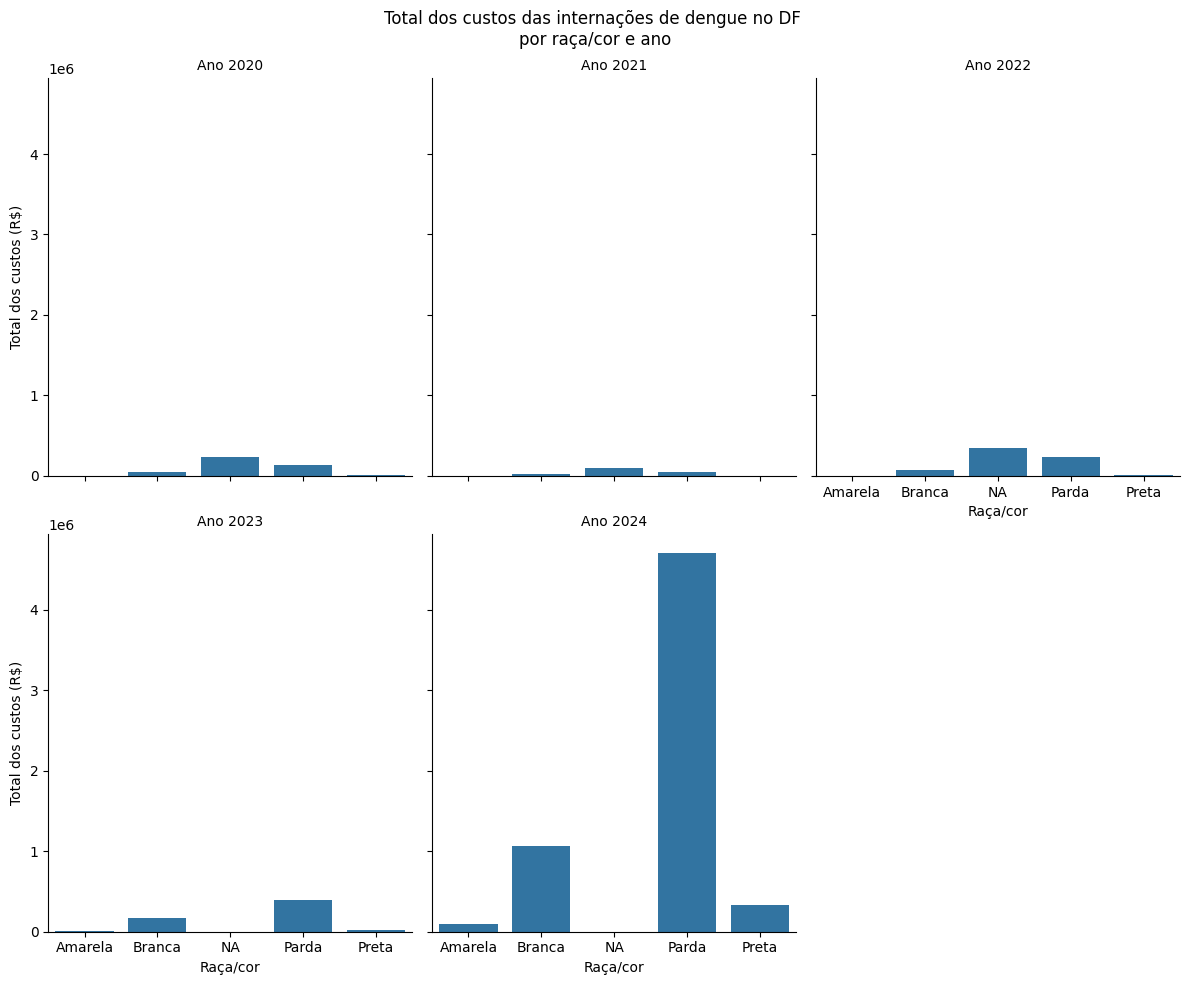

In [426]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_cor_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000)))

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "raca_cor", "vl_total_sum", order=agregado_cor_ano["raca_cor"].unique())

g.set_axis_labels("Raça/cor", "Total dos custos (R$)")

# Ajustar os títulos
plt.suptitle("Total dos custos das internações de dengue no DF \npor raça/cor e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Resiência no DF

In [427]:
dengue_df['mesmo_municipio']=dengue_df[['cd_municipio_res', 'cd_municipio_estab']].apply(lambda x: "Sim" if x.cd_municipio_res == x.cd_municipio_estab else "Não", axis=1)
agregado_mesmo_municipio_ano = agregar_dados(dengue_df, ['mesmo_municipio', 'ano'], ['vl_total'])
agregado_mesmo_municipio_ano

,mesmo_municipio,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,Não,2020,196,93369.14,44.22,7976.86,476.373163,809.133104
1,Não,2021,53,22178.22,44.22,2985.90,418.456981,418.220899
2,Não,2022,149,70956.32,44.22,13954.59,476.216913,1197.897375
3,Não,2023,158,147697.55,44.22,34453.25,934.794620,3368.510104
4,Não,2024,969,704340.24,44.22,42869.27,726.873313,2309.654195
5,Sim,2020,771,332114.00,44.22,23613.34,430.757458,1008.360059
6,Sim,2021,383,154992.11,44.22,19017.10,404.679138,1006.275155
7,Sim,2022,1278,600830.22,40.38,34135.46,470.133192,1439.753049
8,Sim,2023,773,433835.58,40.38,23536.54,561.236197,1341.030907
9,Sim,2024,7573,5513964.14,40.38,54701.14,728.108298,2389.767579


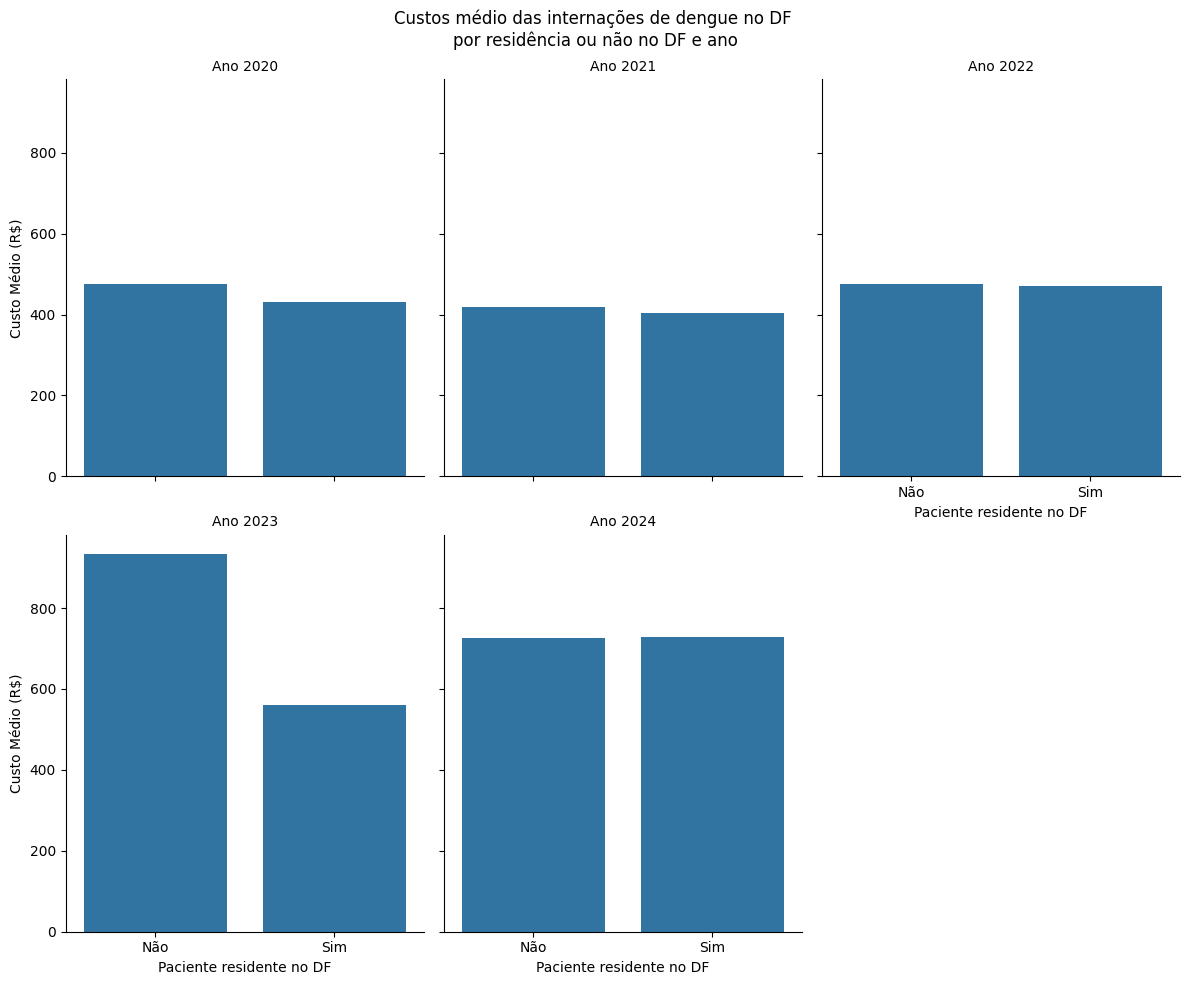

In [428]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_mesmo_municipio_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "mesmo_municipio", "vl_total_mean", order=agregado_mesmo_municipio_ano["mesmo_municipio"].unique())

g.set_axis_labels("Paciente residente no DF", "Custo Médio (R$)")

# Ajustar os títulos
plt.suptitle("Custos médio das internações de dengue no DF \npor residência ou não no DF e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

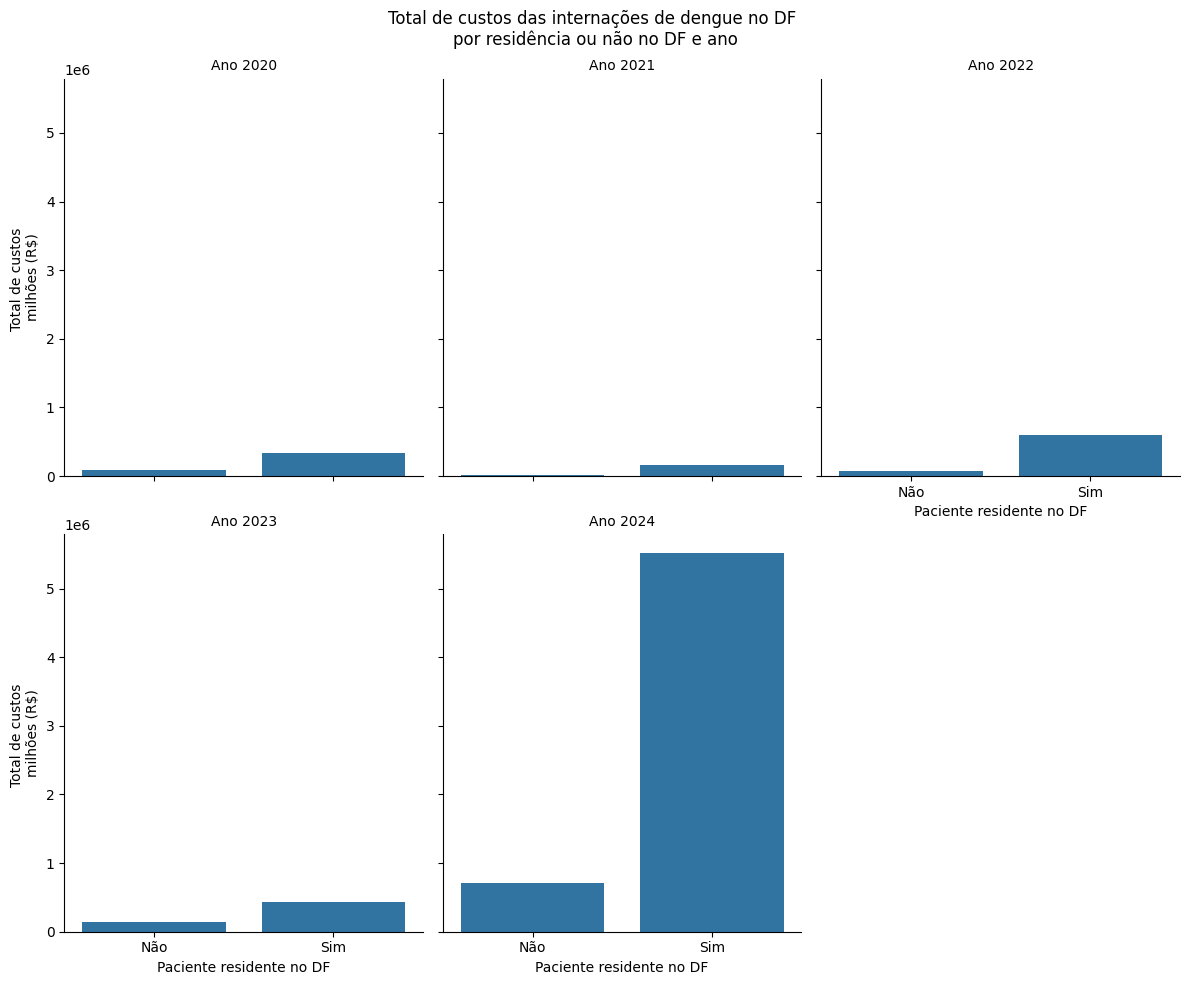

In [429]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_mesmo_municipio_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6)))

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "mesmo_municipio", "vl_total_sum", order=agregado_mesmo_municipio_ano["mesmo_municipio"].unique())

g.set_axis_labels("Paciente residente no DF", "Total de custos \nmilhões (R$)")

# Ajustar os títulos
plt.suptitle("Total de custos das internações de dengue no DF \npor residência ou não no DF e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

### Dengue convencional X hemorrágica

In [430]:
dengue_df['hemorragica']=dengue_df[['cd_diag_princ', 'cd_proc_realizado']].apply(
    lambda x: "Sim" if ((x.cd_diag_princ == 'A91') | (x.cd_proc_realizado == '0303010029')) else "Não", axis = 1
    )
agregado_hemorragica_ano = agregar_dados(dengue_df, ['hemorragica', 'ano'], ['vl_total'])
agregado_hemorragica_ano

,hemorragica,ano,vl_total_count,vl_total_sum,vl_total_min,vl_total_max,vl_total_mean,vl_total_std
0,Não,2020,905,360613.22,44.22,7947.28,398.467646,571.374304
1,Não,2021,416,162581.09,44.22,19017.10,390.819928,945.329750
2,Não,2022,1350,529701.66,40.38,19749.88,392.371600,978.237044
3,Não,2023,882,427613.96,40.38,13560.51,484.823084,960.106153
4,Não,2024,8046,5279680.78,40.38,54701.14,656.187022,2267.886452
5,Sim,2020,62,64869.92,44.22,23613.34,1046.289032,3113.798581
6,Sim,2021,20,14589.24,44.22,4562.36,729.462000,1096.907925
7,Sim,2022,77,142084.88,47.27,34135.46,1845.258182,4314.553157
8,Sim,2023,49,153919.17,194.81,34453.25,3141.207551,6532.653165
9,Sim,2024,496,938623.60,44.22,38661.32,1892.386290,3571.921903


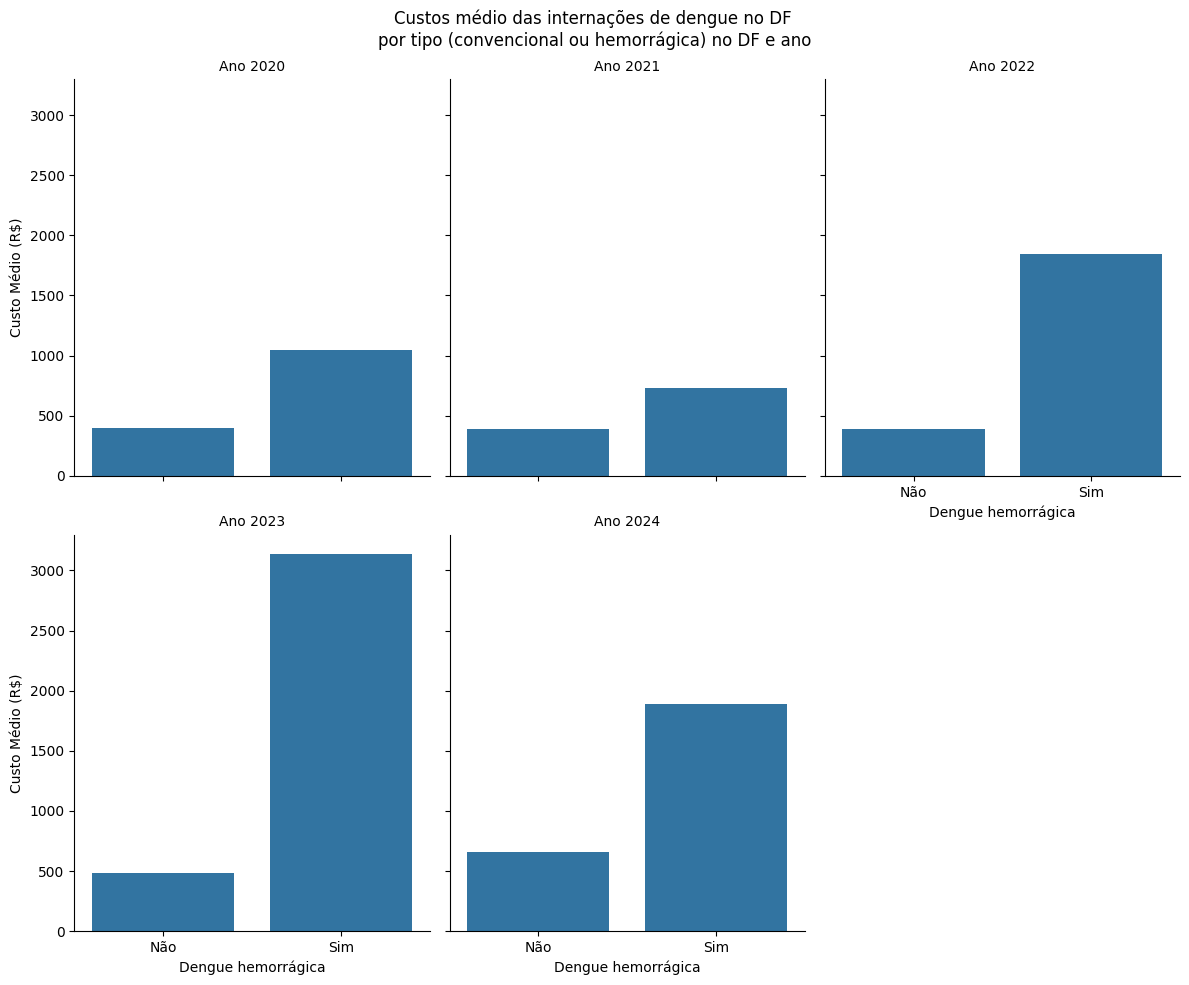

In [431]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_hemorragica_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "hemorragica", "vl_total_mean", order=agregado_hemorragica_ano["hemorragica"].unique())

g.set_axis_labels("Dengue hemorrágica", "Custo Médio (R$)")

# Ajustar os títulos
plt.suptitle("Custos médio das internações de dengue no DF \npor tipo (convencional ou hemorrágica) no DF e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

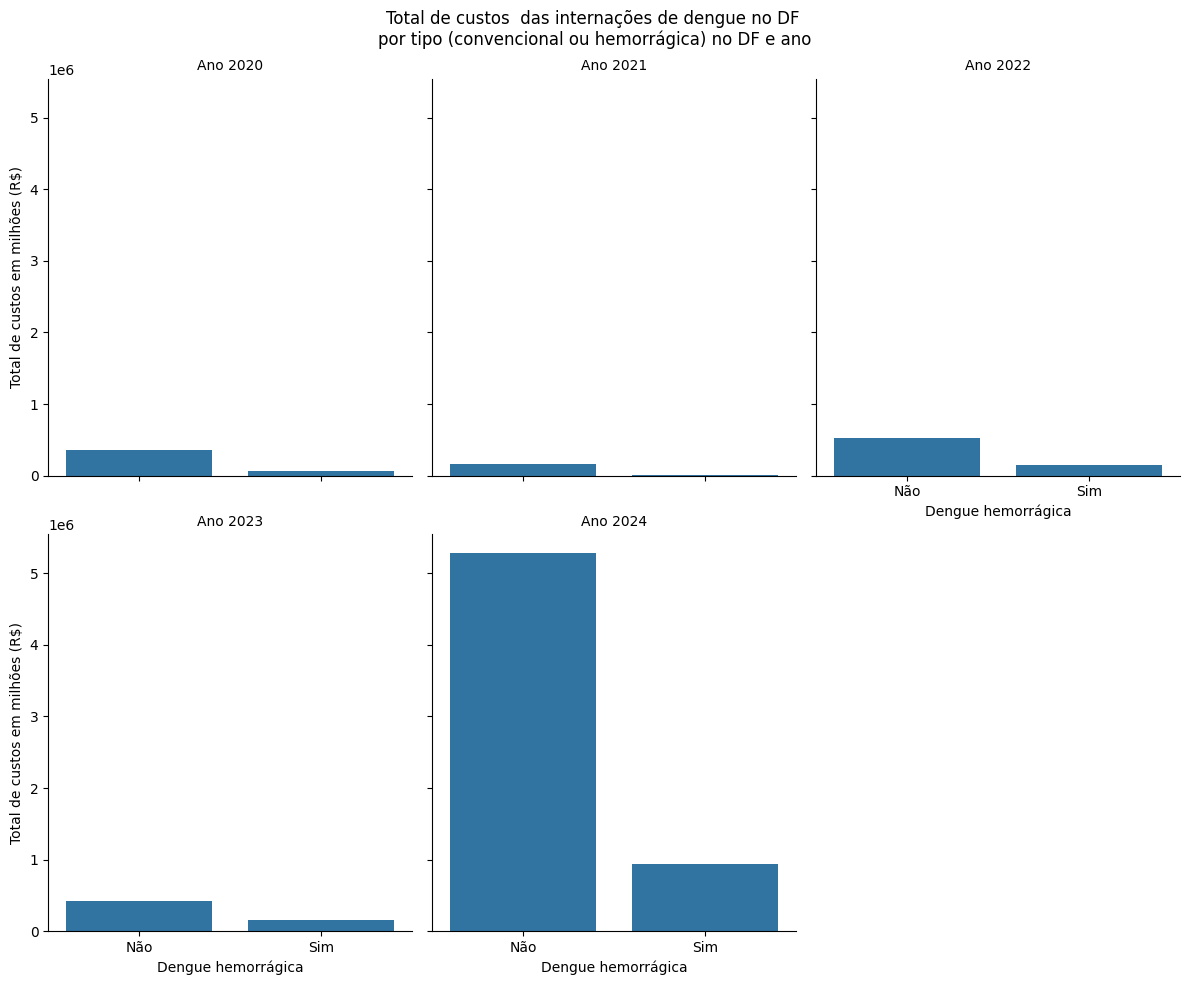

In [432]:
# Criar uma grade de gráficos, separando por 'Ano'
g = sns.FacetGrid(agregado_hemorragica_ano, col="ano", col_wrap=3, height=5, aspect=0.8, sharey=True)  # "col_wrap" define quantas colunas por linha

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000)))

# Aplicar gráfico de barras em cada painel
g.map(sns.barplot, "hemorragica", "vl_total_sum", order=agregado_hemorragica_ano["hemorragica"].unique())

g.set_axis_labels("Dengue hemorrágica", "Total de custos em milhões (R$)")

# Ajustar os títulos
plt.suptitle("Total de custos  das internações de dengue no DF \npor tipo (convencional ou hemorrágica) no DF e ano")
g.set_titles(col_template="Ano {col_name}")
plt.tight_layout()
plt.show()

## Transformação das Variáveis Categóricas

In [452]:
colunas_selecionadas = [
    'qt_diarias_uti',
    'qt_diarias_uti_interm',
    'qt_diarias_acompanhante',
    'qt_diarias',
    'vl_total',
    'qt_dias_permanencia',
    'ano_internacao',
    'mes_internacao',
    'especialidade',
    'sexo',
    'tipo_uti',
    'natureza_juridica',
    'qt_idade_anos',
    'qt_idade_10_anos',
    'carater_atendimento',
    'complexidade',
    'raca_cor',
    'mesmo_municipio',
    'hemorragica',
    'qt_diag_sec'
  ]

dados = dengue_df[colunas_selecionadas]

colunas_categoricas = [col for col in dados.columns if dados[col].dtype == 'object']

dados_encoded = pd.get_dummies(dados, columns=colunas_categoricas, drop_first=True, prefix = [ col for col in colunas_categoricas], prefix_sep = "=")

dados_encoded.head()

,qt_diarias_uti,qt_diarias_uti_interm,qt_diarias_acompanhante,qt_diarias,vl_total,qt_dias_permanencia,ano_internacao,mes_internacao,qt_idade_anos,qt_idade_10_anos,qt_diag_sec,especialidade=Clínica médica,especialidade=Pediatria,sexo=Masculino,tipo_uti=Não utilizou UTI,tipo_uti=UTI II Adulto Covid-19,tipo_uti=UTI II adulto,tipo_uti=UTI II infantil,tipo_uti=UTI II neonatal,tipo_uti=UTI III adulto,tipo_uti=UTI III infantil,tipo_uti=UTI III neonatal,natureza_juridica=Fundação Estadual ou do Distrito Federal,natureza_juridica=Fundação Federal,natureza_juridica=Fundação Privada,natureza_juridica=Serviço Social Autônomo,natureza_juridica=Sociedade Anônima Fechada,natureza_juridica=Sociedade Empresária Limitada,natureza_juridica=Órgão Público do Poder Exec Estadual ou Distr Fed,carater_atendimento=Urgência,complexidade=Média complexidade,raca_cor=Branca,raca_cor=NA,raca_cor=Parda,raca_cor=Preta,mesmo_municipio=Sim,hemorragica=Sim
0,0,0,0,1,287.76,1,2022,1,22.0,20,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,False,True,False
1,0,0,3,3,432.18,3,2021,12,22.0,20,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,False,True,False
2,0,0,8,8,515.78,8,2021,12,4.0,0,0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,False,True,False
3,0,0,2,2,364.50,2,2021,12,27.0,20,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,False
4,0,0,3,3,313.17,3,2022,1,47.0,40,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True


## Selecão e particionamento de dados

In [453]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def selecionar_dados(df, colunas_preditoras, var_alvo):
  variaveis_preditoras = [col for col in df.columns if col in colunas_preditoras or col.startswith(tuple([col + '=' for col in colunas_preditoras]))]
  X = df[variaveis_preditoras]
  y = df[var_alvo]
  return X, y

def particionar_dados(X, y, test_size, random_state):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
  return X_train, X_test, y_train, y_test


## Regressão linear

In [454]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Funções de criação, treinamento e avaliação de modelos de regressão linear


def criar_modelo_reg_linear(X_train, y_train):
  modelo = LinearRegression()
  modelo.fit(X_train, y_train)
  return modelo

def calcular_coeficientes_reg_linear(modelo, X, y):
  coeficientes = pd.DataFrame(modelo.coef_, X.columns, columns=['Coeficiente'])
  return coeficientes.apply(round).sort_values(by='Coeficiente', ascending=False)

def calcular_metricas(modelo, X_test, y_test, y_pred):
  y_pred = modelo.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  print(f"R²: {r2}")

  mse = mean_squared_error(y_test, y_pred)
  print(f"MSE: {mse}")

  mae = mean_absolute_error(y_test, y_pred)
  print(f"MAE: {mae}")

  rmse = np.sqrt(mse)
  print(f"RMSE: {rmse}")

def processar_regressao_linear(modelo,  X, y, X_train, y_train, X_test, y_test, y_pred):
  modelo = criar_modelo_reg_linear(X_train, y_train)
  calcular_metricas_reg_linear(modelo, X_test, y_test, y_pred)
  coeficientes = calcular_coeficientes_reg_linear(modelo, X, y)
  display(coeficientes)



### Árvore de Decisão

In [455]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def criar_modelo_arvore_decisao(X_train, y_train, max_depth, min_samples_split, random_state):
  modelo = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
  modelo.fit(X_train, y_train)

## Processamento dos modelos

In [498]:
def processar_modelos(observacao, df, colunas_preditoras, var_alvo, test_size, part_random_state, tree_max_depth, tree_min_samples_split, tree_random_state):
  output.no_vertical_scroll()
  print("=============================================================================")
  print(f"Colunas preditoras: {colunas_preditoras}")
  print(f"Variável alvo: {var_alvo}")
  print(f"Tamanho do conjunto de teste: {test_size}")
  print(f"Seed do particionamento: {part_random_state}")
  print(f"Observação: {observacao}")
  print("=============================================================================")
  X, y = selecionar_dados(df, colunas_preditoras, var_alvo)
  X_train, X_test, y_train, y_test = particionar_dados(X, y, test_size, part_random_state)
  print("REGRESSÃO LINEAR")
  modelo_lr = criar_modelo_reg_linear(X_train, y_train)
  calcular_metricas_reg_linear(modelo_lr, X_test, y_test, y_pred)
  coeficientes = calcular_coeficientes_reg_linear(modelo_lr, X, y)
  display(coeficientes)
  print("=============================================================================")
  print("ÁRVORE DE DECISÃO")
  print(f"Profundidade máxima: {tree_max_depth}")
  print(f"Mínimo de amostras para divisão: {tree_min_samples_split}")
  print(f"Seed da árvore de decisão: {tree_min_samples_split}")
  criar_modelo_arvore_decisao(X_train, y_train, tree_max_depth, tree_min_samples_split, tree_random_state)
  modelo_tree = DecisionTreeRegressor(max_depth=tree_max_depth, random_state=tree_random_state)
  modelo_tree.fit(X_train, y_train)
  calcular_metricas_reg_linear(modelo_tree, X_test, y_test, y_pred)
  print("=============================================================================")


### Dados de 2020 a 2024

In [499]:

colunas_preditoras = [
    #'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    'tipo_uti',
    #'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    #'hemorragica',
    #'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2020 a 2024', df=dados_encoded, colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)



<IPython.core.display.Javascript object>

Colunas preditoras: ['tipo_uti']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2020 a 2024
REGRESSÃO LINEAR
R²: 0.36669728861102047
MSE: 2699923.9050673908
MAE: 330.97551452295244
RMSE: 1643.144517401738


,Coeficiente
tipo_uti=UTI II neonatal,3248.0
tipo_uti=UTI II adulto,1227.0
tipo_uti=UTI III adulto,986.0
tipo_uti=UTI III infantil,802.0
tipo_uti=UTI II Adulto Covid-19,0.0
tipo_uti=UTI III neonatal,0.0
tipo_uti=UTI II infantil,-1341.0
tipo_uti=Não utilizou UTI,-4922.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.3716165945381408
MSE: 2678951.704206539
MAE: 330.1088661106711
RMSE: 1636.7503487723895


In [500]:

colunas_preditoras = [
    'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    #'tipo_uti',
    #'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    #'hemorragica',
    #'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2020 a 2024', df=dados_encoded, colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)

<IPython.core.display.Javascript object>

Colunas preditoras: ['qt_diarias_uti']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2020 a 2024
REGRESSÃO LINEAR
R²: 0.9234452763628282
MSE: 326371.45661433274
MAE: 153.73828498106178
RMSE: 571.2892932782241


,Coeficiente
qt_diarias_uti,693.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.9157280229025048
MSE: 359271.99015743606
MAE: 155.78371193993712
RMSE: 599.393018108683


In [501]:

colunas_preditoras = [
    #'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    'tipo_uti',
    'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    'hemorragica',
    'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2020 a 2024', df=dados_encoded, colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)

<IPython.core.display.Javascript object>

Colunas preditoras: ['tipo_uti', 'natureza_juridica', 'hemorragica', 'qt_diag_sec']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2020 a 2024
REGRESSÃO LINEAR
R²: 0.3760688488088726
MSE: 2659970.6584588853
MAE: 338.02701265718775
RMSE: 1630.9416477786338


,Coeficiente
tipo_uti=UTI III adulto,3246.0
tipo_uti=UTI II neonatal,2760.0
natureza_juridica=Sociedade Anônima Fechada,1851.0
tipo_uti=UTI III infantil,799.0
qt_diag_sec,190.0
natureza_juridica=Sociedade Empresária Limitada,107.0
tipo_uti=UTI III neonatal,-0.0
tipo_uti=UTI II Adulto Covid-19,-0.0
hemorragica=Sim,-214.0
tipo_uti=UTI II adulto,-423.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.3087053662429249
MSE: 2947157.6128767747
MAE: 337.45016791562637
RMSE: 1716.7287534368306


In [502]:

colunas_preditoras = [
    #'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    #'tipo_uti',
    'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    'hemorragica',
    'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2020 a 2024', df=dados_encoded, colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)

<IPython.core.display.Javascript object>

Colunas preditoras: ['natureza_juridica', 'hemorragica', 'qt_diag_sec']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2020 a 2024
REGRESSÃO LINEAR
R²: 0.24700329268421406
MSE: 3210208.6000232175
MAE: 432.82362114607304
RMSE: 1791.7055003608202


,Coeficiente
natureza_juridica=Sociedade Anônima Fechada,1614.0
hemorragica=Sim,469.0
qt_diag_sec,433.0
natureza_juridica=Sociedade Empresária Limitada,-71.0
natureza_juridica=Fundação Privada,-4189.0
natureza_juridica=Fundação Federal,-6388.0
natureza_juridica=Serviço Social Autônomo,-6451.0
natureza_juridica=Órgão Público do Poder Exec Estadual ou Distr Fed,-6528.0
natureza_juridica=Fundação Estadual ou do Distrito Federal,-6544.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.1960092883313036
MSE: 3427608.476719734
MAE: 446.2585104363518
RMSE: 1851.380154565705


### Dados de 2024

In [503]:

colunas_preditoras = [
    #'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    'tipo_uti',
    #'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    #'hemorragica',
    #'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2024', df=dados_encoded[dados_encoded['ano_internacao']==2024], colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)



<IPython.core.display.Javascript object>

Colunas preditoras: ['tipo_uti']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2024
REGRESSÃO LINEAR
R²: 0.3589866957508874
MSE: 3028888.989284383
MAE: 383.41128532159627
RMSE: 1740.3703598040227


,Coeficiente
tipo_uti=UTI II Adulto Covid-19,-0.0
tipo_uti=UTI II neonatal,-15875.0
tipo_uti=UTI III infantil,-17287.0
tipo_uti=UTI II adulto,-17387.0
tipo_uti=UTI III neonatal,-18273.0
tipo_uti=UTI II infantil,-20678.0
tipo_uti=UTI III adulto,-20812.0
tipo_uti=Não utilizou UTI,-23865.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.3589866957508876
MSE: 3028888.989284382
MAE: 383.41128532159564
RMSE: 1740.3703598040224


In [504]:

colunas_preditoras = [
    'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    #'tipo_uti',
    #'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    #'hemorragica',
    #'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2024', df=dados_encoded[dados_encoded['ano_internacao']==2024], colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)



<IPython.core.display.Javascript object>

Colunas preditoras: ['qt_diarias_uti']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2024
REGRESSÃO LINEAR
R²: 0.9747733718214444
MSE: 119199.79791418476
MAE: 139.95274517646087
RMSE: 345.25323736959336


,Coeficiente
qt_diarias_uti,702.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.9627083504218923
MSE: 176208.9274132851
MAE: 143.43639964264491
RMSE: 419.77247100457305


In [511]:

colunas_preditoras = [
    #'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    'tipo_uti',
    'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    'hemorragica',
    #'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2024', df=dados_encoded[dados_encoded['ano_internacao']==2024], colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)



<IPython.core.display.Javascript object>

Colunas preditoras: ['tipo_uti', 'natureza_juridica', 'hemorragica']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2024
REGRESSÃO LINEAR
R²: 0.38231064462056574
MSE: 2918679.651272662
MAE: 397.823676494415
RMSE: 1708.4143675562618


,Coeficiente
natureza_juridica=Sociedade Anônima Fechada,1364.0
tipo_uti=UTI II Adulto Covid-19,0.0
natureza_juridica=Fundação Estadual ou do Distrito Federal,-0.0
natureza_juridica=Fundação Privada,0.0
natureza_juridica=Sociedade Empresária Limitada,-26.0
hemorragica=Sim,-296.0
natureza_juridica=Fundação Federal,-2880.0
natureza_juridica=Serviço Social Autônomo,-2884.0
natureza_juridica=Órgão Público do Poder Exec Estadual ou Distr Fed,-2916.0
tipo_uti=UTI II neonatal,-16582.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.3038688300353153
MSE: 3289329.6002235166
MAE: 392.15466401308737
RMSE: 1813.6509036260304


In [515]:

colunas_preditoras = [
    #'qt_diarias_uti',
    #'qt_diarias_uti_interm',
    #'qt_diarias_acompanhante',
    #'qt_diarias',
    #'qt_dias_permanencia',
    #'ano_internacao',
    #'mes_internacao',
    #'especialidade',
    #'sexo',
    #'tipo_uti',
    'natureza_juridica',
    #'qt_idade_anos',
    #'carater_atendimento',
    #'complexidade',
    #'raca_cor',
    #'mesmo_municipio',
    'hemorragica',
    'qt_diag_sec'
  ]

processar_modelos(observacao= 'Dados de 2024', df=dados_encoded[dados_encoded['ano_internacao']==2024], colunas_preditoras=colunas_preditoras, var_alvo='vl_total', test_size=0.2, part_random_state=42, tree_max_depth=10, tree_min_samples_split=10, tree_random_state=42)



<IPython.core.display.Javascript object>

Colunas preditoras: ['natureza_juridica', 'hemorragica', 'qt_diag_sec']
Variável alvo: vl_total
Tamanho do conjunto de teste: 0.2
Seed do particionamento: 42
Observação: Dados de 2024
REGRESSÃO LINEAR
R²: 0.2633890504743106
MSE: 3480602.9447676064
MAE: 503.3842495179836
RMSE: 1865.6374097791902


,Coeficiente
natureza_juridica=Sociedade Anônima Fechada,1037.0
hemorragica=Sim,518.0
qt_diag_sec,505.0
natureza_juridica=Fundação Estadual ou do Distrito Federal,0.0
natureza_juridica=Fundação Privada,0.0
natureza_juridica=Sociedade Empresária Limitada,-404.0
natureza_juridica=Serviço Social Autônomo,-7226.0
natureza_juridica=Órgão Público do Poder Exec Estadual ou Distr Fed,-7230.0
natureza_juridica=Fundação Federal,-7263.0


ÁRVORE DE DECISÃO
Profundidade máxima: 10
Mínimo de amostras para divisão: 10
Seed da árvore de decisão: 10
R²: 0.25696233919966305
MSE: 3510970.169422783
MAE: 502.0788154870645
RMSE: 1873.7583006948316
